In [65]:
setwd('./placeholder_project/code/')
source('./placeholder_project/code/jupyter_R/myFun.R')
source('./placeholder_project/code/jupyter_R/markerlist.R')
sample_info = read.csv('./placeholder_project//sample_information/sample_information.csv',row.names = 1)
#base_path='./placeholder_analysis/round_cluster02/round0/'

In [2]:
myHeatmapPeaks <- function (marker.peaks, obj = NULL, group = "seurat_clusters", 
    top = 10, assay = "ATAC", min_log2FC = 0.25, max_pval = 0.05, 
    color = circlize::colorRamp2(c(-2, 0, 2), c("#045a8d", "white", 
        "#a50f15")), row_fontsize = 3, column_fontsize = 3, cell_meta = NULL, 
    mat = NULL, filter_pseudogene = FALSE, lwd = 0.05) 
{
    if (!is.null(obj)) {
        cell_meta = obj@meta.data
        mat = obj@assays[[assay]]$data
    }
    if (filter_pseudogene) {
        marker.peaks = filter_pseudoGene(marker.peaks)
    }
    top_peaks = marker.peaks %>% dplyr::filter(avg_log2FC >= 
        min_log2FC & p_val_adj <= max_pval) %>% group_by(cluster) %>% 
        top_n(top, avg_log2FC) %>% arrange(cluster, -avg_log2FC)
    cell_meta = cell_meta[order(cell_meta[, group]), ]
    top_mat = mat[top_peaks$gene, rownames(cell_meta)]
    top_mat = t(apply(top_mat, 1, scale))
    ht = Heatmap(as.matrix(top_mat), col = color, cluster_rows = F, 
        cluster_columns = F, show_row_names = F, show_column_names = F, 
        column_split = cell_meta[, group], row_split = top_peaks$cluster, 
        use_raster = TRUE, column_gap = unit(0, "mm"), row_gap = unit(0, 
            "mm"), border = TRUE, border_gp = gpar(col = "black", 
            lwd = lwd), row_title_gp = gpar(fontsize = row_fontsize), 
        column_title_gp = gpar(fontsize = column_fontsize))
    return(ht)
}

In [ ]:
pseudoObj_peaks <- readRDS(glue('./placeholder_analysis/round_cluster02/round0/pseudoObj_peaks.rds'))
pseudoObj_cells <- readRDS(glue('./placeholder_analysis/round_cluster02/round0/pseudoObj_cells.rds'))

In [3]:
merge_path='./placeholder_analysis/round_cluster02/merge'

In [ ]:

umap = read.csv(glue('{merge_path}/cell_meta.csv'))
rownames(umap) = umap$X
umap$sample_id = factor(sample_info[umap$sample, 'sample_time'], levels=sample_levels)
umap$Time = factor(sample_info[umap$sample, 'Time'], levels=time_levels)

In [4]:
new_celltype = read.csv('./placeholder_analysis/round_cluster02/merge/celltype_modify.csv')
rownames(new_celltype) = new_celltype$Celltype_round4
new_celltype$modify_name = new_celltype$Celltype_round4_new
new_celltype$new_name = paste0(new_celltype$modify_name,'.', new_celltype$cluster_num)

In [16]:
pseudoObj_cells = subset(pseudoObj_cells, cells = umap$X)
pseudoObj_cells

An object of class Seurat 
2 features across 1185619 samples within 1 assay 
Active assay: ATAC (2 features, 0 variable features)
 2 layers present: counts, data
 1 dimensional reduction calculated: umap

In [ ]:
pseudoObj_cells@meta.data[umap$X, colnames(umap)] = umap
Idents(pseudoObj_cells) = pseudoObj_cells$Celltype_round1
pseudoObj_cells@meta.data[,'nCount_ATAC'] = pseudoObj_cells$n_fragment
pseudoObj_cells@meta.data[,'nFeature_ATAC'] = pseudoObj_cells$n_peaks

In [25]:
pseudoObj_cells@meta.data$Celltype_round1_new = new_celltype[pseudoObj_cells$Celltype_round4, 'new_name']

In [21]:
pseudoObj_cells[["umap"]] <- CreateDimReducObject(
  embeddings = as.matrix(pseudoObj_cells@meta.data[,c('UMAP_1','UMAP_2')]),
  key = "UMAP_",
  assay = DefaultAssay(pseudoObj_cells)
)
pseudoObj_cells[["tsne"]] <- CreateDimReducObject(
  embeddings = as.matrix(pseudoObj_cells@meta.data[,c('TSNE_1','TSNE_2')]),
  key = "UMAP_",
  assay = DefaultAssay(pseudoObj_cells)
)

Rasterizing points since number of points exceeds 100,000.
To disable this behavior set `raster=FALSE`

Rasterizing points since number of points exceeds 100,000.
To disable this behavior set `raster=FALSE`



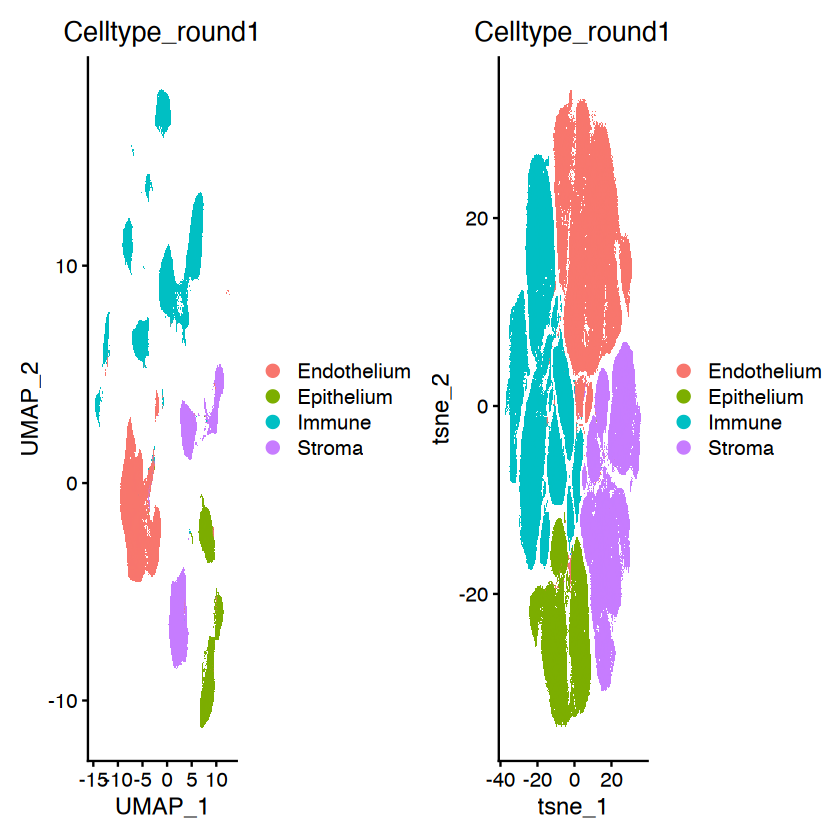

In [30]:
a=DimPlot(pseudoObj_cells, reduction = 'umap', group.by = 'Celltype_round1')
b=DimPlot(pseudoObj_cells, reduction = 'tsne', group.by = 'Celltype_round1')
a+b

In [27]:
merge_path='./placeholder_analysis/round_cluster02_gene/'
mat <- Matrix::readMM(glue("{merge_path}/gene_X_sparse.mtx"))
row_names <- read.csv(glue("{merge_path}/gene_X_sparse_index.csv"), header = T)[,1]
col_names <- read.csv(glue("{merge_path}/gene_X_sparse_columns.csv"), header = T)[,1]
row_names = gsub(':','-',row_names)
rownames(mat) <- row_names
colnames(mat) <- col_names

gene_activate_srt = CreateSeuratObject(mat, min.cells = 0, min.features = 0, project='GeneActivity')

In [28]:
umap2=umap[umap$X%in%colnames(gene_activate_srt),]
gene_activate_srt@meta.data[umap2$X, colnames(umap2)] = umap2

gene_activate_srt[['umap']]=CreateDimReducObject(embeddings = as.matrix(gene_activate_srt@meta.data[,c('UMAP_1', 'UMAP_2')]),
                                                 key='UMAP_')
gene_activate_srt[['tsne']]=CreateDimReducObject(embeddings = as.matrix(gene_activate_srt@meta.data[,c('TSNE_1', 'TSNE_2')]),
                                                 key='TSNE_')

Rasterizing points since number of points exceeds 100,000.
To disable this behavior set `raster=FALSE`

Rasterizing points since number of points exceeds 100,000.
To disable this behavior set `raster=FALSE`



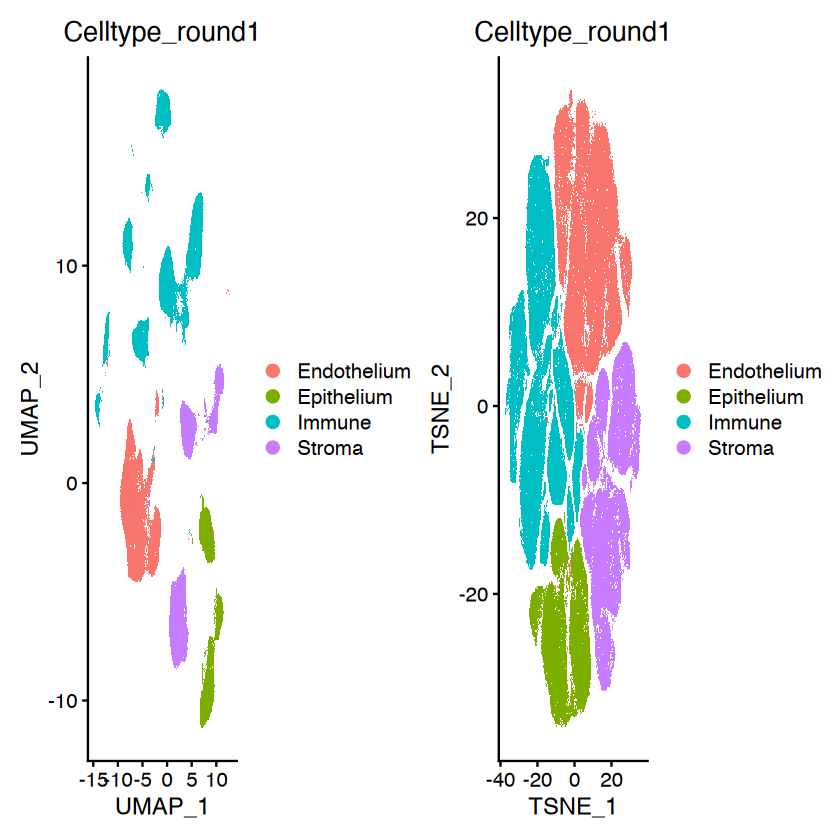

In [29]:
a=DimPlot(gene_activate_srt, reduction = 'umap', group.by = 'Celltype_round1')
b=DimPlot(gene_activate_srt, reduction = 'tsne', group.by = 'Celltype_round1')
a+b

In [31]:
saveRDS(gene_activate_srt, './placeholder_analysis/round_cluster02/merge/gene_activate_srt.rds')
saveRDS(pseudoObj_cells, './placeholder_analysis/round_cluster02/merge/pseudoObj_srt.rds')

In [4]:
pseudoObj_peaks <- readRDS(glue('./placeholder_analysis/round_cluster02/round0/pseudoObj_peaks.rds'))
pseudoObj_cells <- readRDS(glue('./placeholder_analysis/round_cluster02/merge/pseudoObj_srt.rds'))

In [5]:
gene_activate_srt = readRDS('./placeholder_analysis/round_cluster02/merge/gene_activate_srt.rds')

In [6]:
drop_cells = rownames(gene_activate_srt@meta.data[is.na(gene_activate_srt$Celltype_round1),])

gene_activate_srt = subset(gene_activate_srt, cells=drop_cells, invert=TRUE)

In [7]:
gene_activate_srt

An object of class Seurat 
17034 features across 592800 samples within 1 assay 
Active assay: RNA (17034 features, 0 variable features)
 1 layer present: counts
 2 dimensional reductions calculated: umap, tsne

In [9]:
# Load differential peak matrix
tmp_dir='./placeholder_analysis/round_cluster02/merge/'
peak_mat <- Matrix::readMM(glue("{tmp_dir}/peak_cluster_markers_sparse.mtx"))
row_names <- read.csv(glue("{tmp_dir}/peak_cluster_markers_sparse_index.csv"), header = T)[,1]
col_names <- read.csv(glue("{tmp_dir}/peak_cluster_markers_sparse_columns.csv"), header = T)[,1]
row_names = gsub(':','-',row_names)
rownames(peak_mat) <- row_names
colnames(peak_mat) <- col_names

In [8]:
output_dir='./placeholder_output/raw_figure_output/Supp01/'

# Round1

In [ ]:
round_num='Round1'
type_name='All'
#output_dir='../pycode/round_cluster_02_after/celltype_marker/'
marker = read.csv(glue('../pycode/round_cluster_02_after/celltype_marker//{round_num}_All_marker_know.csv'))

colnames(marker)[c(2,5,6,7)] = c('cluster', 'avg_log2FC', 'p_val','p_val_adj')
marker$gene_name=marker$gene

In [33]:
head(marker)

X    cluster     names                    scores   avg_log2FC p_val p_val_adj
1  429 Endothelium chr16:18775729-18776230  204.9957 7.188558   0     0        
2  261 Endothelium chr5:38146463-38146964   222.0085 7.054439   0     0        
3  388 Endothelium chr8:104101335-104101836 208.6916 7.033219   0     0        
4 1799 Endothelium chr6:91218371-91218872   149.5629 6.840414   0     0        
5 2677 Endothelium chr2:28211644-28212145   132.4856 6.718635   0     0        
6   55 Endothelium chr16:18776520-18777021  276.3274 6.696075   0     0        
  pct_nz_group pct_nz_reference gene  gene_biotype   distance type
1 0.12399142   0.0008939476     Cldn5 protein_coding 616      exon
2 0.14245935   0.0011790444     Nsg1  protein_coding   0      gap 
3 0.12811847   0.0010751532     Cdh5  protein_coding   0      utr 
4 0.06980278   0.0005871061     Fbln2 protein_coding   0      utr 
5 0.05514636   0.0005146239     Olfm1 protein_coding   0      gap 
6 0.20911771   0.0025586230     Cldn5 protein_coding   0      cds 
  FindDiffMethod celltype    gene_name
1 peak           Endothelium Cldn5    
2 peak           Endothelium Nsg1     
3 peak           Endothelium Cdh5     
4 peak           Endothelium Fbln2    
5 peak           Endothelium Olfm1    
6 peak           Endothelium Cldn5

In [34]:
marker2 = marker%>%filter(FindDiffMethod=='gene')
marker2 = marker2[marker2$gene%in%rownames(gene_activate_srt),]

marker2$avg_log2FC = marker2$scores
marker2=marker2[!duplicated(marker2$gene_name),]

top_peaks = marker2 %>% 
    dplyr::filter(avg_log2FC >=0.25&p_val_adj <=0.05) %>%
    group_by(cluster) %>% 
    top_n(10,avg_log2FC) %>%
    arrange(cluster, -avg_log2FC)

In [47]:
dim(gene_activate_srt)
dim(gene_activate_srt@meta.data)

[1]  17034 594532

[1] 594532     63

Scale for colour is already present.
Adding another scale for colour, which will replace the existing scale.
Scale for size is already present.
Adding another scale for size, which will replace the existing scale.


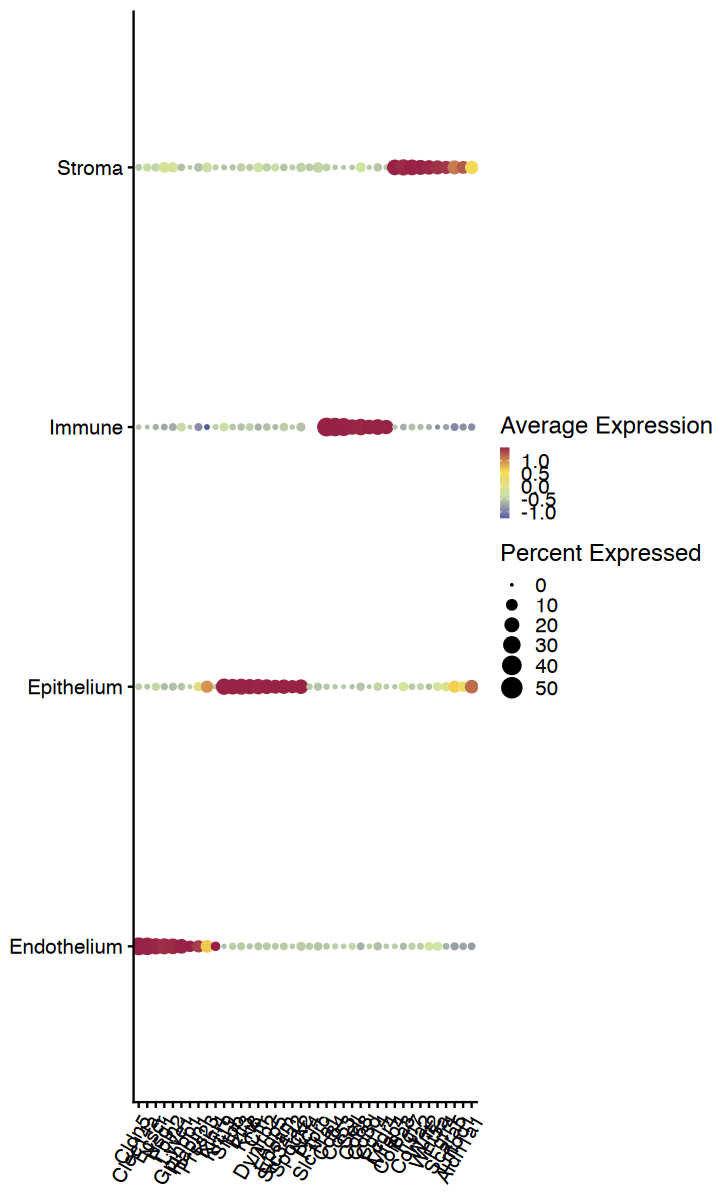

In [53]:
options(repr.plot.width=6, repr.plot.height=10)
a=DotPlot(gene_activate_srt, 
        features = unique(top_peaks$gene),
        group.by='Celltype_round1')+
    scale_color_gradientn(colors = c('#565ca2','#cce5a6','#f7d84f','#972245'))+
    scale_size_continuous(range=c(0,5), limits = c(0,50))+
    #coord_flip()+
    theme(panel.grid = element_blank(),
        axis.text.x = element_text(angle = 60, hjust=1,vjust=1),
        axis.title = element_blank(),
        strip.background = element_blank(),
        legend.key.height = unit(3,'mm'),
        legend.key.size =  unit(2,'mm'))
a

In [55]:
ggsave(glue('{output_dir}/Round1_dotplot.pdf'), a,
       width=12, height=3, units='in', dpi=600, bg='transparent')

 [1] "Ncf4"    "Ptprc"   "Slc11a1" "Cd84"    "Cd53"    "Sell"    "Cd68"   
 [8] "Cd3d"    "Cd14"    "Fcgr4"  


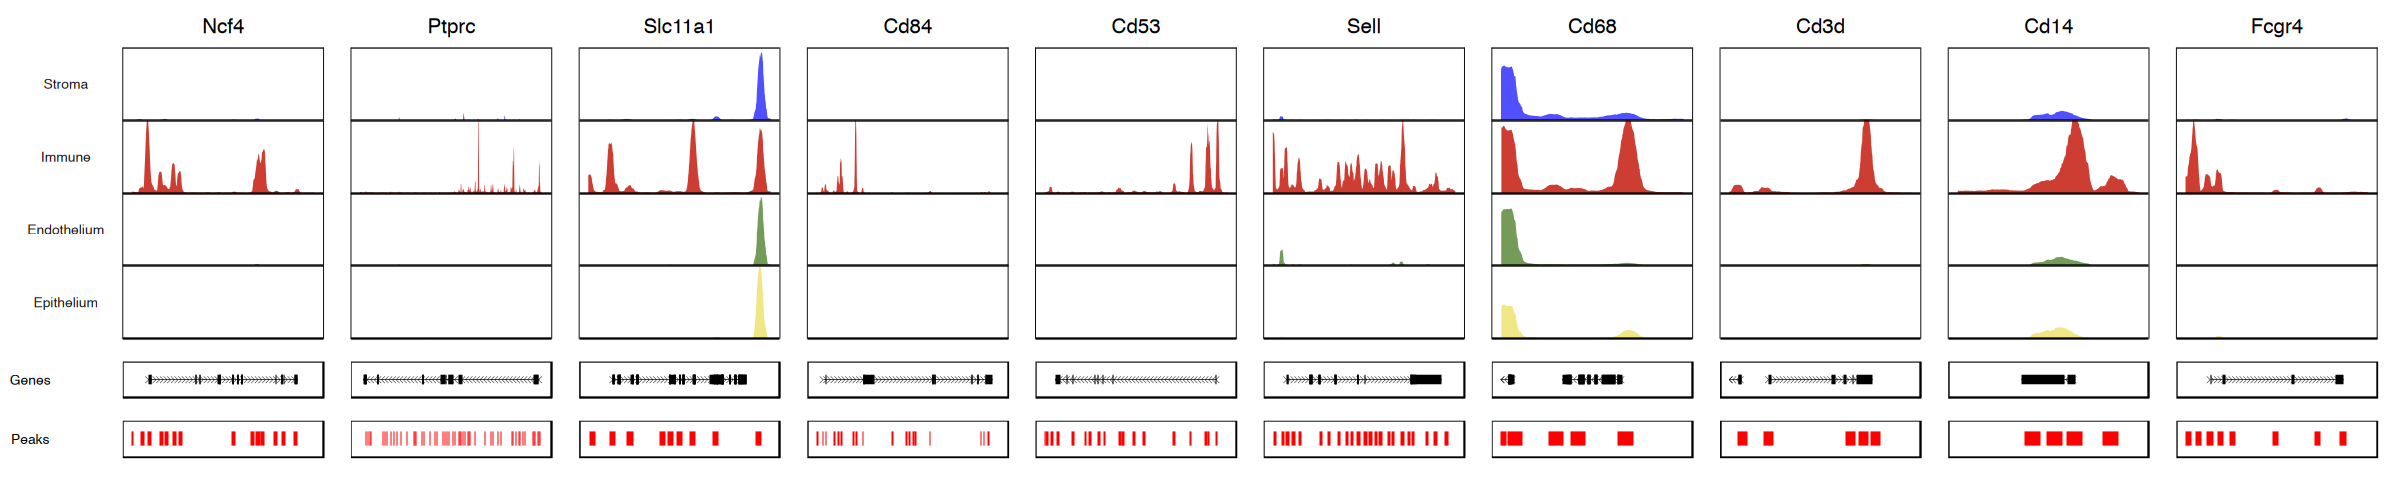

In [60]:
genes_id = top_peaks[top_peaks$cluster=='Immune','gene',drop=T]
print(genes_id)
ncol = length(genes_id)
suppressMessages(suppressWarnings({
    plot_res =myCoveragePlotMultiple(pseudoObj_cells,pseudoObj_peaks,region = genes_id,
                                 ncol=ncol,
                                 ymax='q95', window=500, heights = c(20,1,1),
                                 extend.upstream = 2000, 
                                 extend.downstream = 2000)
    a=myCoverageModify(plot_res, ncol=ncol,region = genes_id,
                 group_color=NULL, genes_color=c('black', 'black'), peaks_color='red',
                 line_color_with_group=F)
}))
options(repr.plot.width=2*ncol, repr.plot.height=4)
a

In [61]:
ggsave(glue('{output_dir}/Round1_immune_coverageplot.pdf'), a,
       width=12, height=3, units='in', dpi=600, bg='transparent')

 [1] "Cldn5"   "Clec14a" "Ecscr"   "Nsg1"    "Fbln2"   "Lyve1"   "Gpihbp1"
 [8] "Hapln1"  "Prss23"  "Klhl4"  


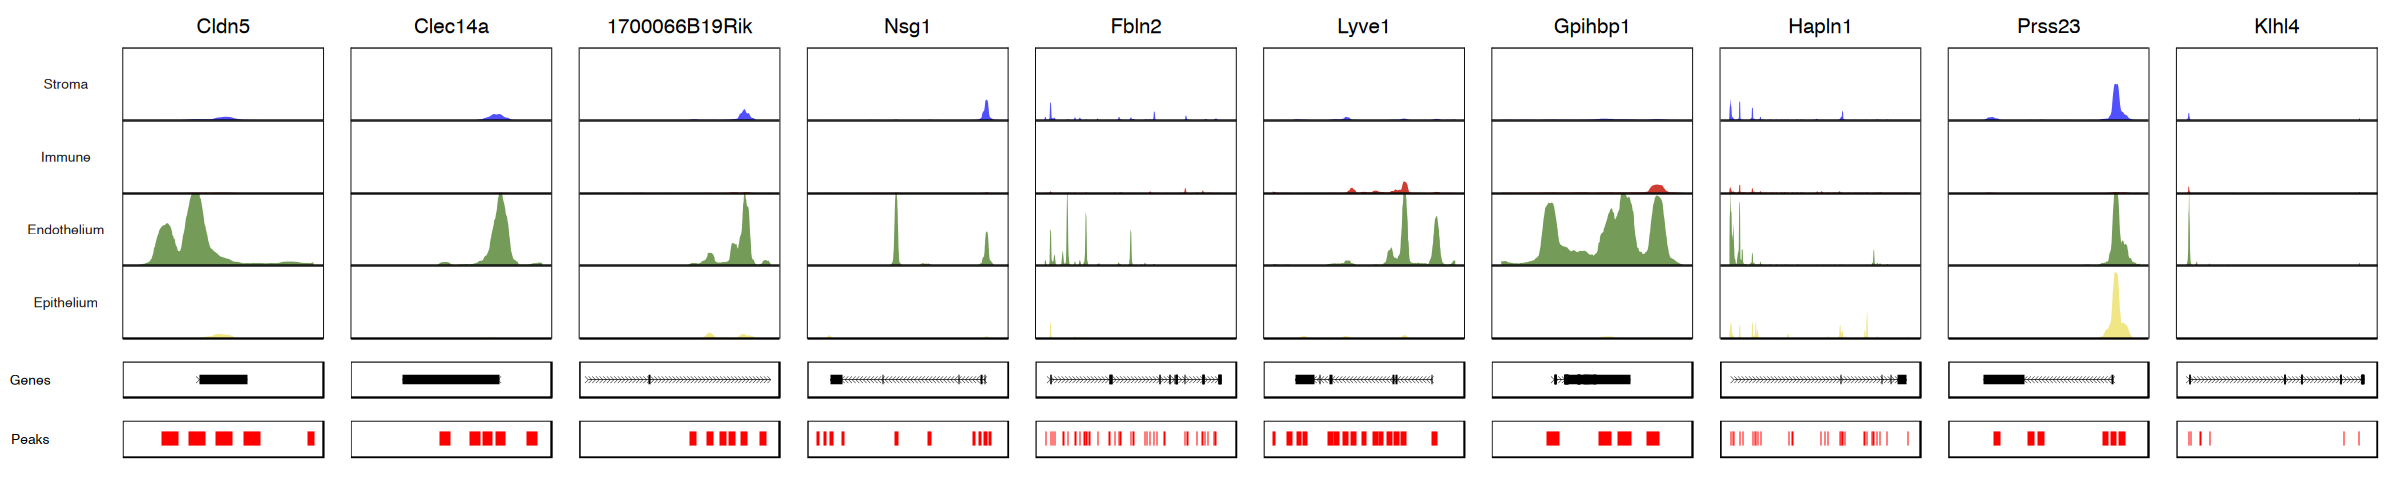

In [62]:
genes_id = top_peaks[top_peaks$cluster=='Endothelium','gene',drop=T]
print(genes_id)
ncol = length(genes_id)
suppressMessages(suppressWarnings({
    plot_res =myCoveragePlotMultiple(pseudoObj_cells,pseudoObj_peaks,region = genes_id,
                                 ncol=ncol,
                                 ymax='q95', window=500, heights = c(20,1,1),
                                 extend.upstream = 2000, 
                                 extend.downstream = 2000)
    a=myCoverageModify(plot_res, ncol=ncol,region = genes_id,
                 group_color=NULL, genes_color=c('black', 'black'), peaks_color='red',
                 line_color_with_group=F)
}))
options(repr.plot.width=2*ncol, repr.plot.height=4)
a
ggsave(glue('{output_dir}/Round1_endo_coverageplot.pdf'), a,
       width=12, height=3, units='in', dpi=600, bg='transparent')

 [1] "Krt19"   "Sftpb"   "Elf3"    "Krt8"    "Cftr"    "Dynlrb2" "Aqp5"   
 [8] "Epcam"   "Slc34a2" "Spock2" 


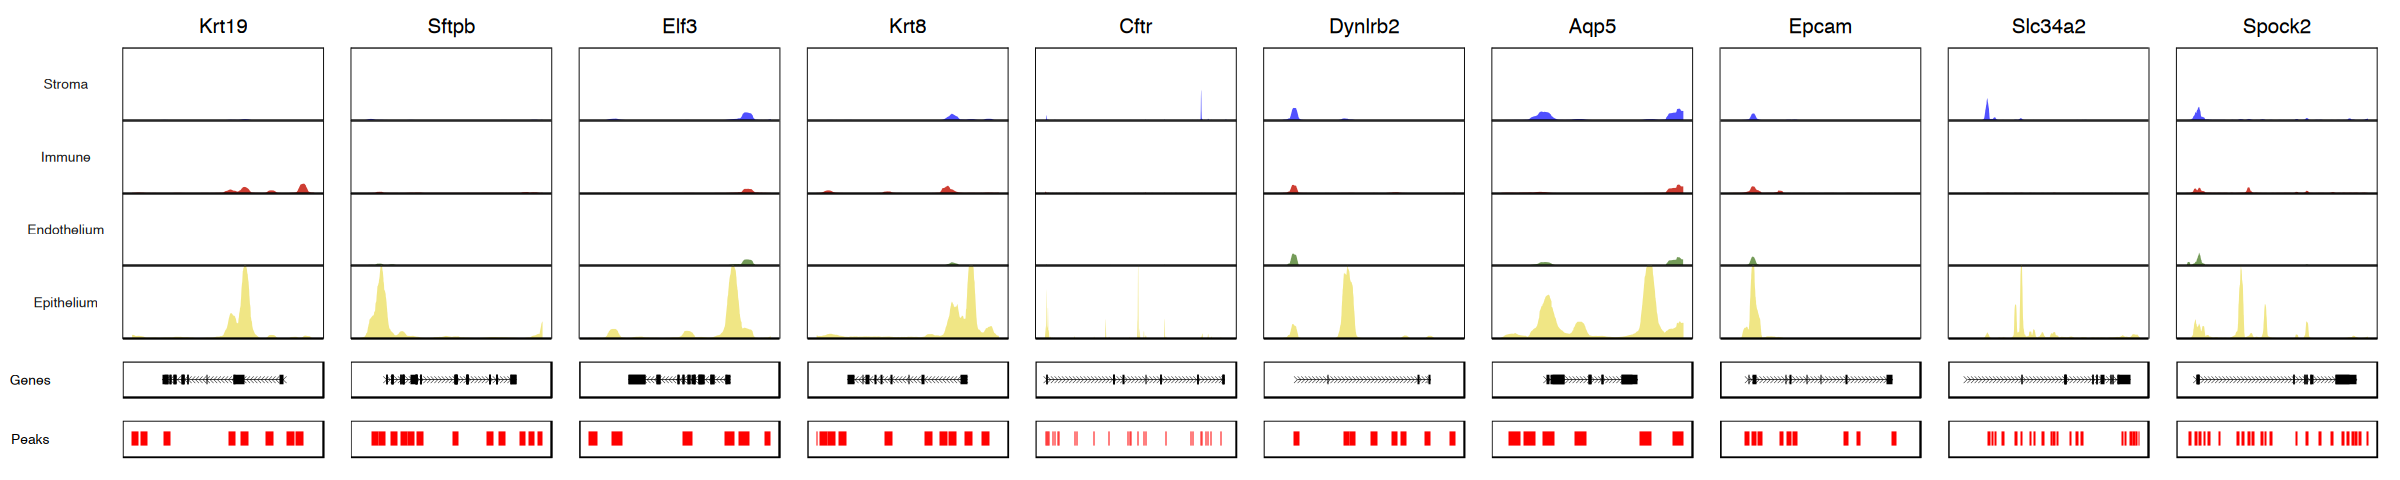

In [63]:
genes_id = top_peaks[top_peaks$cluster=='Epithelium','gene',drop=T]
print(genes_id)
ncol = length(genes_id)
suppressMessages(suppressWarnings({
    plot_res =myCoveragePlotMultiple(pseudoObj_cells,pseudoObj_peaks,region = genes_id,
                                 ncol=ncol,
                                 ymax='q95', window=500, heights = c(20,1,1),
                                 extend.upstream = 2000, 
                                 extend.downstream = 2000)
    a=myCoverageModify(plot_res, ncol=ncol,region = genes_id,
                 group_color=NULL, genes_color=c('black', 'black'), peaks_color='red',
                 line_color_with_group=F)
}))
options(repr.plot.width=2*ncol, repr.plot.height=4)
a
ggsave(glue('{output_dir}/Round1_epi_coverageplot.pdf'), a,
       width=12, height=3, units='in', dpi=600, bg='transparent')

 [1] "Mfap4"   "Col6a3"  "Fgf7"    "Col1a2"  "Wnt2"    "Wnt5a"   "Fgfr4"  
 [8] "Scara5"  "Lmod1"   "Aldh1a1"


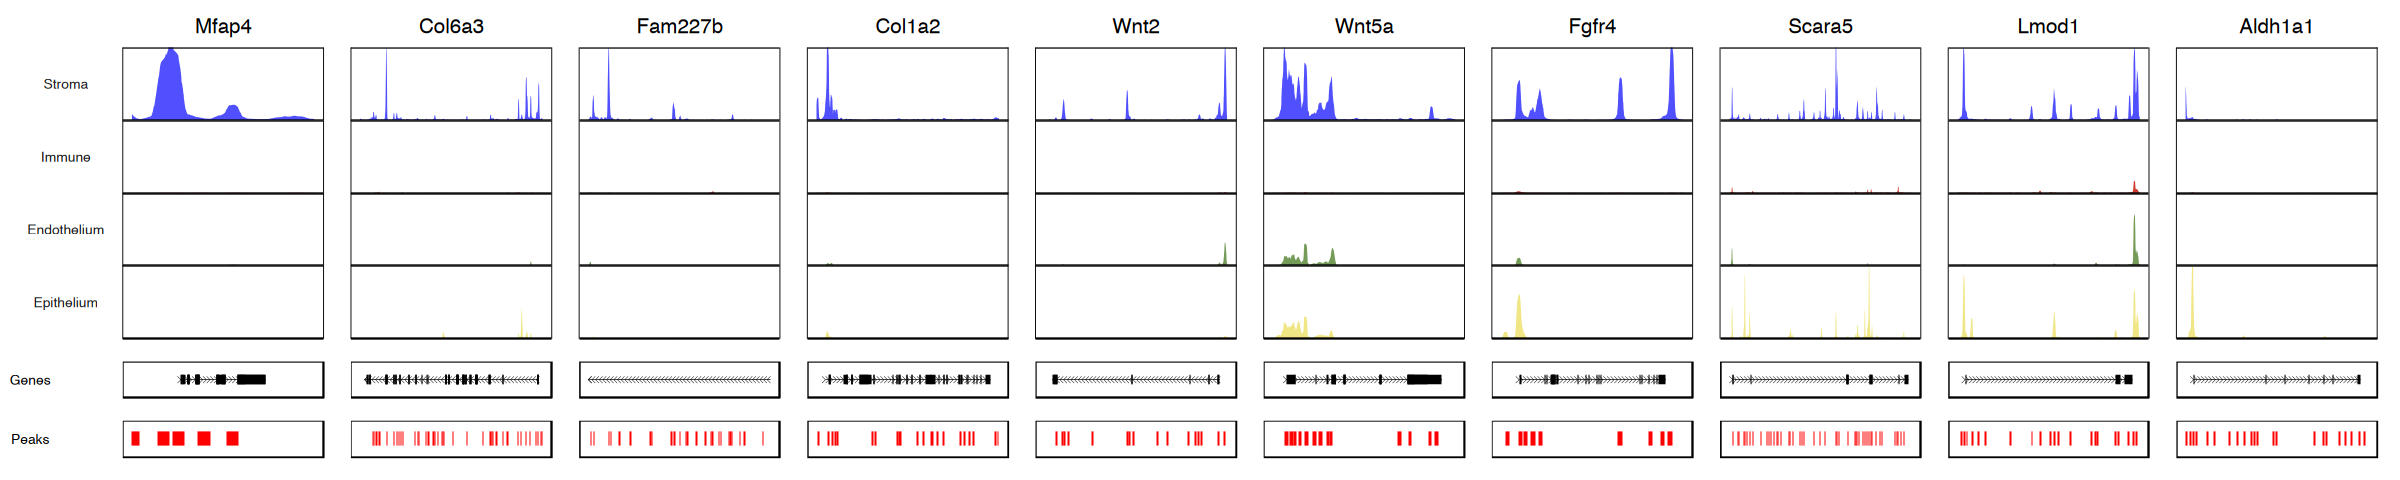

In [64]:
genes_id = top_peaks[top_peaks$cluster=='Stroma','gene',drop=T]
print(genes_id)
ncol = length(genes_id)
suppressMessages(suppressWarnings({
    plot_res =myCoveragePlotMultiple(pseudoObj_cells,pseudoObj_peaks,region = genes_id,
                                 ncol=ncol,
                                 ymax='q95', window=500, heights = c(20,1,1),
                                 extend.upstream = 2000, 
                                 extend.downstream = 2000)
    a=myCoverageModify(plot_res, ncol=ncol,region = genes_id,
                 group_color=NULL, genes_color=c('black', 'black'), peaks_color='red',
                 line_color_with_group=F)
}))
options(repr.plot.width=2*ncol, repr.plot.height=4)
a
ggsave(glue('{output_dir}/Round1_Stromal_coverageplot.pdf'), a,
       width=12, height=3, units='in', dpi=600, bg='transparent')

In [67]:
head(marker %>% 
    filter(FindDiffMethod=='peak'))

X    cluster     names                    scores   avg_log2FC p_val p_val_adj
1  429 Endothelium chr16:18775729-18776230  204.9957 7.188558   0     0        
2  261 Endothelium chr5:38146463-38146964   222.0085 7.054439   0     0        
3  388 Endothelium chr8:104101335-104101836 208.6916 7.033219   0     0        
4 1799 Endothelium chr6:91218371-91218872   149.5629 6.840414   0     0        
5 2677 Endothelium chr2:28211644-28212145   132.4856 6.718635   0     0        
6   55 Endothelium chr16:18776520-18777021  276.3274 6.696075   0     0        
  pct_nz_group pct_nz_reference gene  gene_biotype   distance type
1 0.12399142   0.0008939476     Cldn5 protein_coding 616      exon
2 0.14245935   0.0011790444     Nsg1  protein_coding   0      gap 
3 0.12811847   0.0010751532     Cdh5  protein_coding   0      utr 
4 0.06980278   0.0005871061     Fbln2 protein_coding   0      utr 
5 0.05514636   0.0005146239     Olfm1 protein_coding   0      gap 
6 0.20911771   0.0025586230     Cldn5 protein_coding   0      cds 
  FindDiffMethod celltype    gene_name
1 peak           Endothelium Cldn5    
2 peak           Endothelium Nsg1     
3 peak           Endothelium Cdh5     
4 peak           Endothelium Fbln2    
5 peak           Endothelium Olfm1    
6 peak           Endothelium Cldn5

In [11]:
tmp_markers = marker %>% 
    filter(FindDiffMethod=='peak') %>%
    group_by(cluster) %>% 
    top_n(100,scores) %>%
    mutate(names=gsub(':','-',names)) %>%
    mutate(gene=names)

In [12]:
same_peaks = intersect(tmp_markers$names, rownames(peak_mat))

In [13]:
tmp_mat2=peak_mat[same_peaks, colnames(gene_activate_srt)]

In [14]:
tmp_markers = tmp_markers %>%
    filter(names%in%same_peaks)

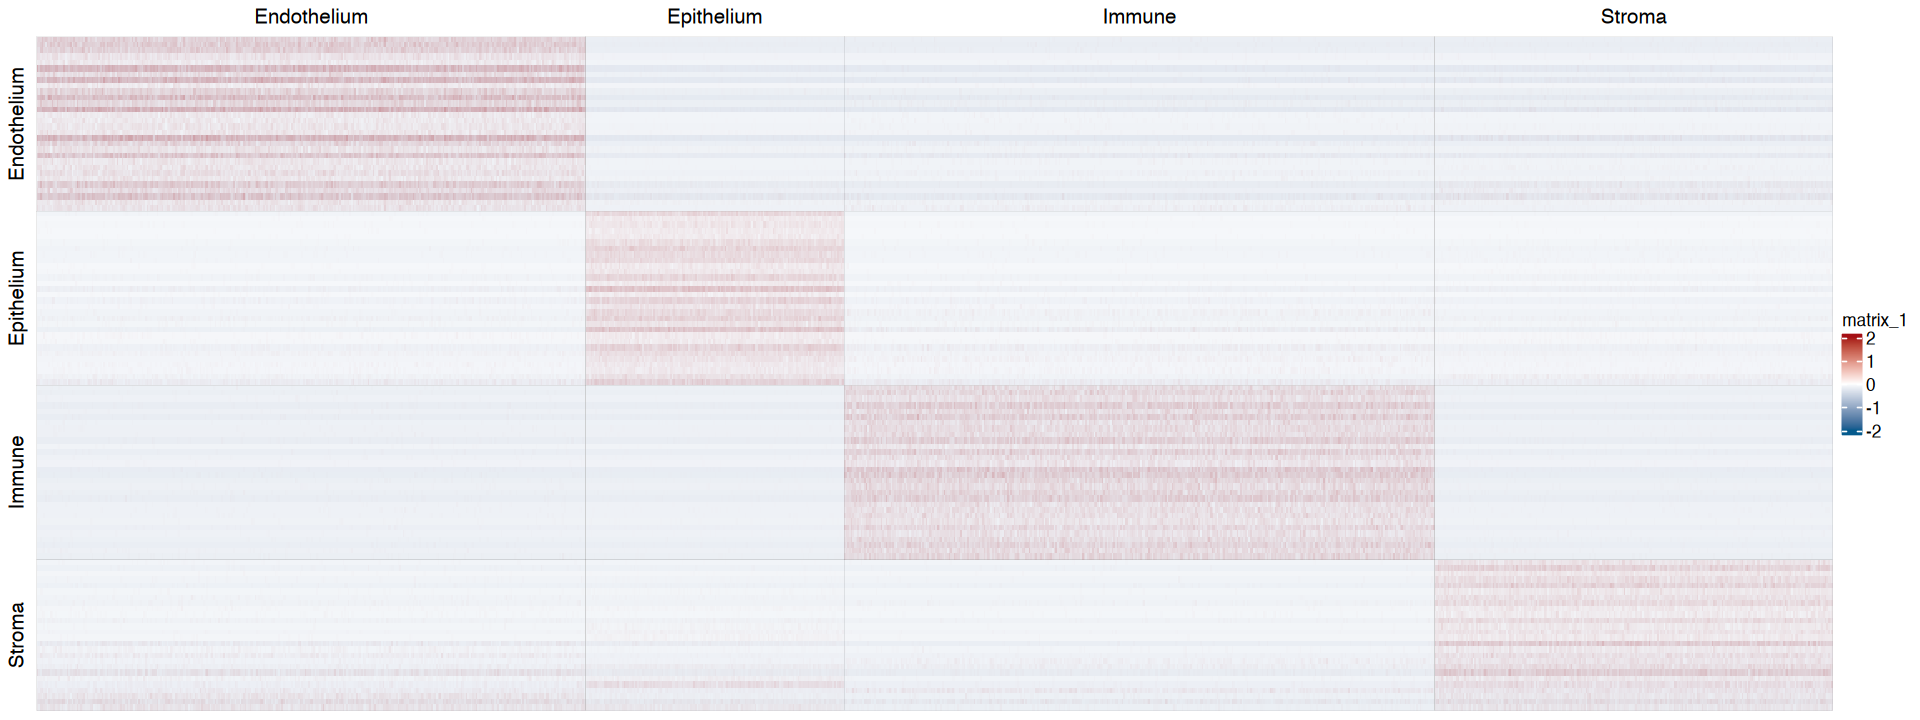

In [15]:
x=myHeatmapPeaks(mat=tmp_mat2, 
                 cell_meta=gene_activate_srt@meta.data, 
                 marker.peaks=tmp_markers,
                 group='Celltype_round1',
                 top=30,assay='ATAC',
                 min_log2FC=0.25,max_pval=0.05,
                 color=circlize::colorRamp2(c(-2,0,2),c("#045a8d","white","#a50f15")),
                 row_fontsize=12, column_fontsize=12)
options(repr.plot.width=16, repr.plot.height=6)
draw(x)

In [17]:
output_dir

[1] "../pycode/round_cluster_02_after/celltype_marker/"

In [16]:
pdf(glue('{output_dir}/Round1_peak_heatmap.pdf'), width = 10,height = 6)
draw(x)
dev.off()

agg_record_1406053153 
                    2

# Round4

In [75]:
new_celltype = read.csv('./placeholder_analysis/round_cluster02/merge/celltype_modify.csv')
rownames(new_celltype) = new_celltype$Celltype_round4
new_celltype$modify_name = new_celltype$Celltype_round4_new
new_celltype$new_name = paste0(new_celltype$modify_name,'.', new_celltype$cluster_num)

## Immune

In [66]:
tmp_srt_gene = subset(gene_activate_srt, Celltype_round1=='Immune')
tmp_srt_peak = subset(pseudoObj_cells, Celltype_round1=='Immune')

Rasterizing points since number of points exceeds 100,000.
To disable this behavior set `raster=FALSE`

Rasterizing points since number of points exceeds 100,000.
To disable this behavior set `raster=FALSE`



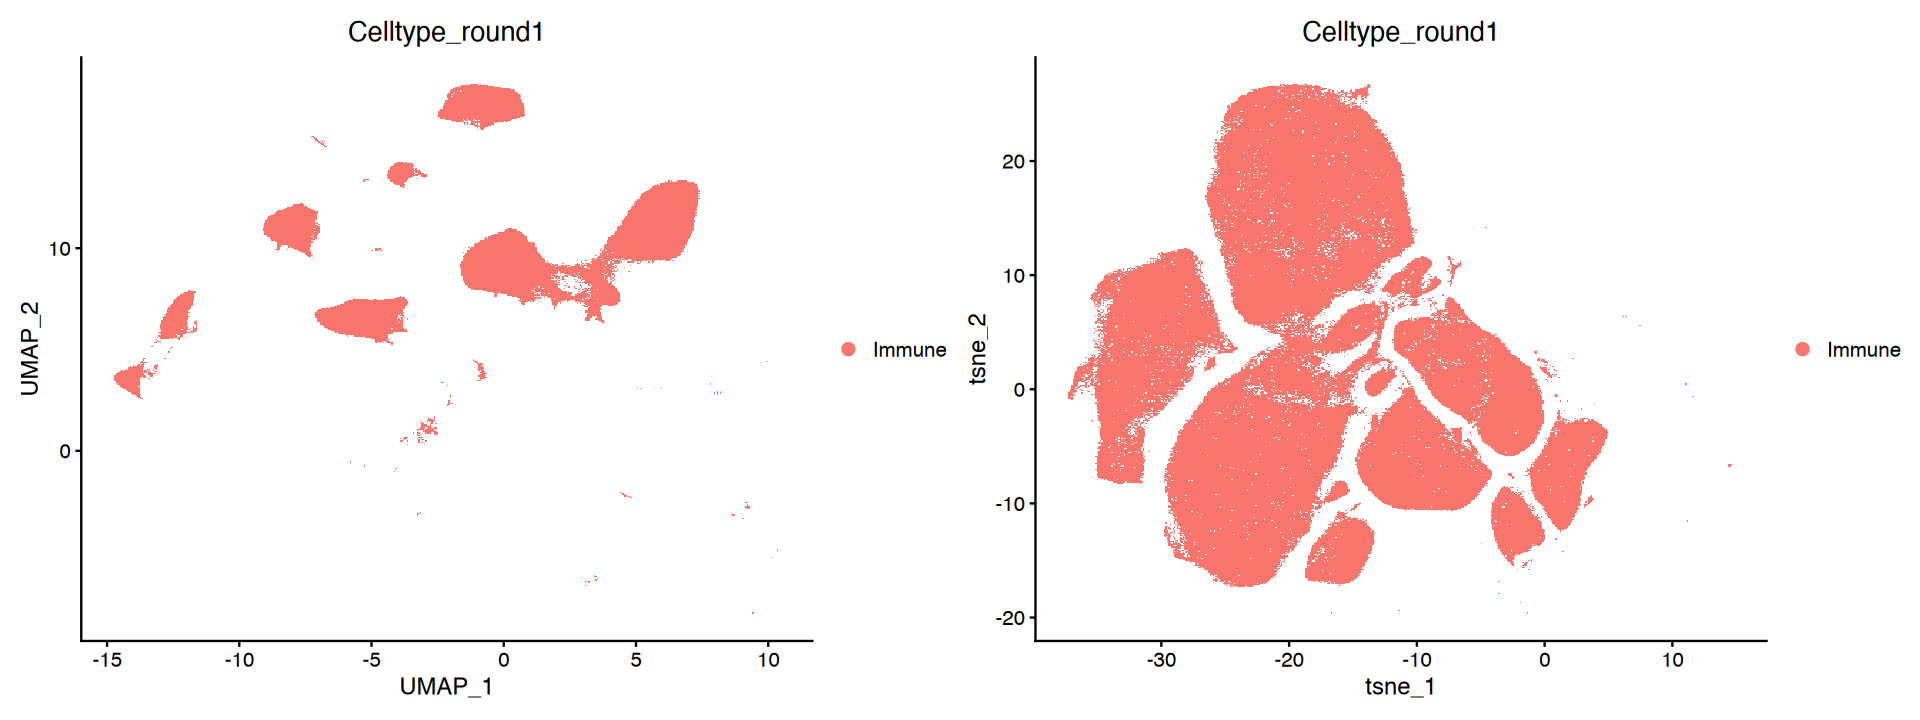

In [16]:
options(repr.plot.width=16, repr.plot.height=6)
a=DimPlot(tmp_srt_peak, reduction = 'umap', group.by = 'Celltype_round1')
b=DimPlot(tmp_srt_peak, reduction = 'tsne', group.by = 'Celltype_round1')
a+b

In [67]:
tmp_umap = read.csv(glue('./placeholder_analysis/round_cluster02/round1/Immune/cell_meta.csv'))
rownames(tmp_umap) = tmp_umap$X
tmp_same_bc = intersect(rownames(tmp_umap), colnames(tmp_srt_peak))

In [68]:
tmp_srt_peak = subset(tmp_srt_peak, cells=tmp_same_bc)
tmp_umap = tmp_umap[tmp_same_bc,]

In [69]:
tmp_srt_peak@meta.data$UMAP_1 = NULL
tmp_srt_peak@meta.data$UMAP_2 = NULL

In [70]:
tmp_srt_peak[['umap']]=NULL
tmp_srt_peak[['tsne']]=NULL

In [71]:
tmp_srt_peak[['umap']] <- CreateDimReducObject(
  embeddings = as.matrix(tmp_umap[colnames(tmp_srt_peak),c('UMAP_1','UMAP_2')]),
  key = "UMAP_",
  assay = DefaultAssay(tmp_srt_peak)
)
tmp_srt_peak[['tsne']] <- CreateDimReducObject(
  embeddings = as.matrix(tmp_umap[colnames(tmp_srt_peak),c('TSNE_1','TSNE_2')]),
  key = "TSNE_",
  assay = DefaultAssay(tmp_srt_peak)
)

In [141]:
round4_color = readRDS('./placeholder_analysis/round_cluster02/merge/round4_color.rds')
new_celltype$color = round4_color[new_celltype$Celltype_round4]
write.table(new_celltype, './placeholder_analysis/round_cluster02/merge/celltype_modify_color.csv', sep=',', row.names = F, quote = F)

round4_num = readRDS('./placeholder_analysis/round_cluster02/merge/round4_cluster_num.rds')
round4_color2 = round4_color
names(round4_color2) = round4_num[names(round4_color2)]

names(round4_color) = new_celltype[names(round4_color), 'new_name']

In [ ]:
tmp_srt_peak$new_name = as.vector(new_celltype[as.vector(tmp_srt_peak$Celltype_round4), 'new_name'])
tmp_srt_peak$name_num = as.vector(new_celltype[as.vector(tmp_srt_peak$Celltype_round4), 'cluster_num'])
tmp_srt_gene$new_name = as.vector(new_celltype[as.vector(tmp_srt_gene$Celltype_round4), 'new_name'])
tmp_srt_gene$name_num = as.vector(new_celltype[as.vector(tmp_srt_gene$Celltype_round4), 'cluster_num'])

In [135]:
round4_color2['2']

2 
"#F0E685FF"

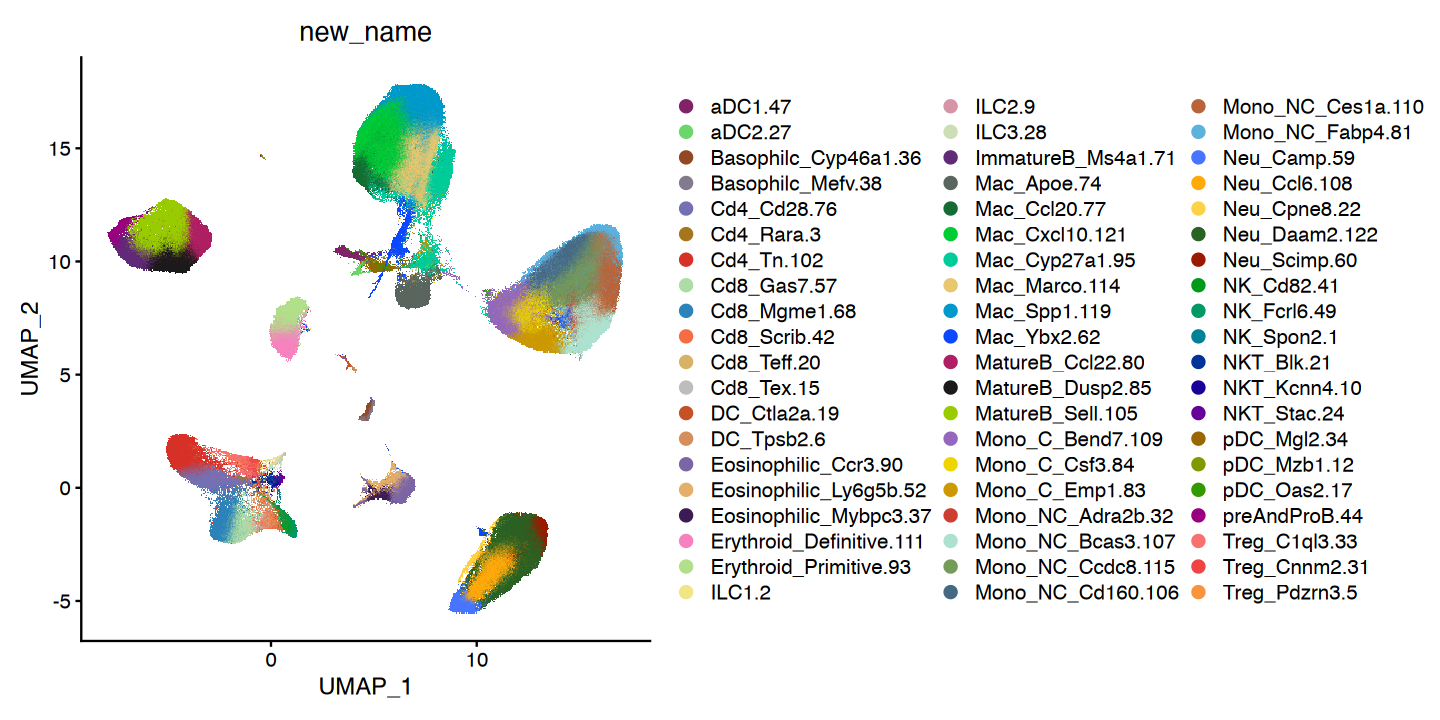

In [115]:
options(repr.plot.width=12, repr.plot.height=6)
a=DimPlot(tmp_srt_peak, reduction = 'umap', group.by = 'new_name', raster = T)+
    scale_colour_manual(values = round4_color)
#b=DimPlot(tmp_srt_peak, reduction = 'tsne', group.by = 'Celltype_round2', raster = T)
a

In [ ]:

ggsave(glue('{output_dir}/Immune_round4_umap.pdf'), 
       a,
       width=14, height=6, units='in', dpi=600, bg='transparent')

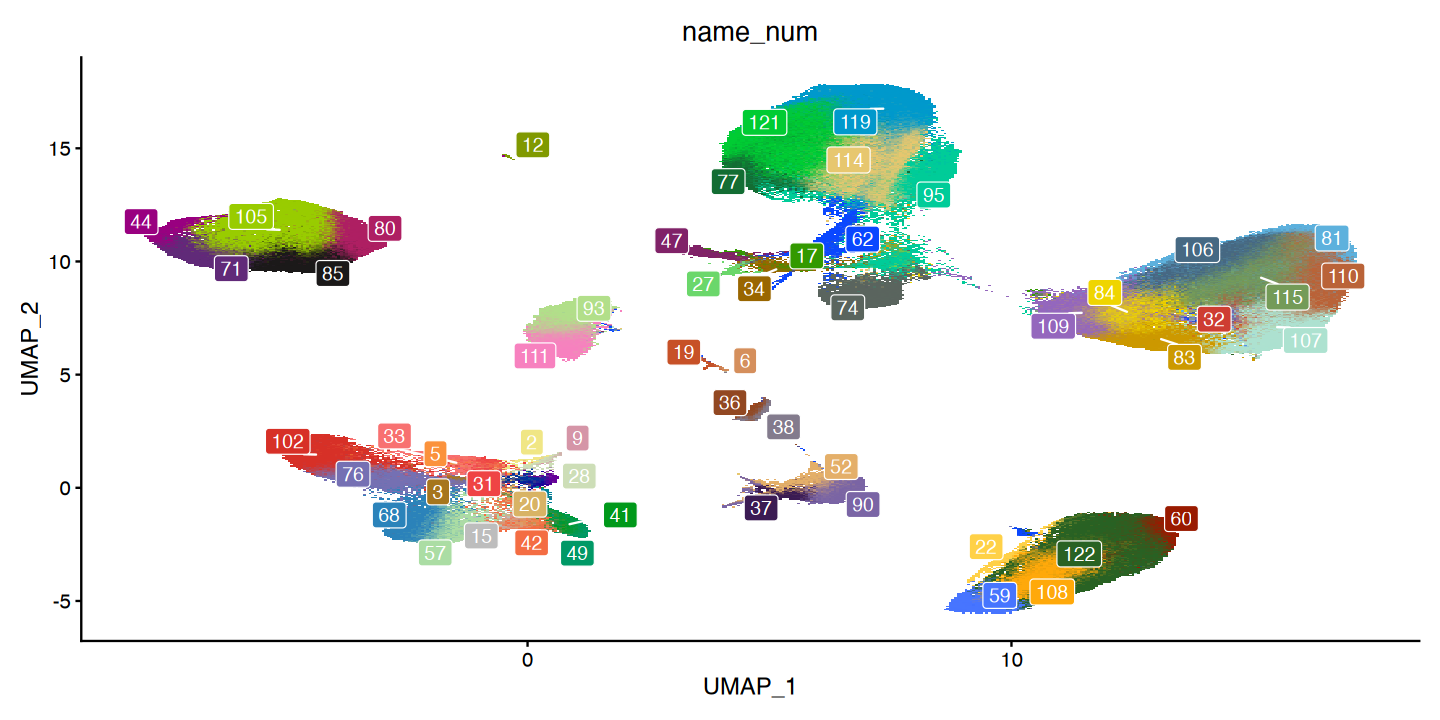

In [117]:
options(repr.plot.width=12, repr.plot.height=6)
a=DimPlot(tmp_srt_peak, reduction = 'umap', group.by = 'name_num',
     raster = T, label = T, label.box=T,repel=T,label.color = "white", #alpha=0.5,
     cols=round4_color2)+NoLegend()
#b=DimPlot(tmp_srt_peak, reduction = 'tsne', group.by = 'Celltype_round2', raster = T)
a

In [ ]:

ggsave(glue('{output_dir}/Immune_round4_umap(label).pdf'), 
       a,
       width=6, height=6, units='in', dpi=600, bg='transparent')

In [119]:
tmp_srt_gene <- NormalizeData(tmp_srt_gene, normalization.method = "LogNormalize", scale.factor = 10000)
tmp_srt_gene <- FindVariableFeatures(tmp_srt_gene, selection.method = "vst", nfeatures = 2000)
all.genes <- rownames(tmp_srt_gene)
tmp_srt_gene <- ScaleData(tmp_srt_gene, features = all.genes)
tmp_srt_gene

Normalizing layer: counts

Finding variable features for layer counts

Centering and scaling data matrix



An object of class Seurat 
17034 features across 194899 samples within 1 assay 
Active assay: RNA (17034 features, 2000 variable features)
 3 layers present: counts, data, scale.data
 2 dimensional reductions calculated: umap, tsne

In [117]:
Idents(tmp_srt_gene) = tmp_srt_gene$Celltype_round4
gene_markers = FindAllMarkers(tmp_srt_gene, max.cells.per.ident = 300)

Calculating cluster Cd8_Mgme1

Calculating cluster preAndProB

Calculating cluster Myeloid_Macorphage

Calculating cluster Myeloid_Macorphage_Spp1

Calculating cluster Monocytes_NonClassical_Cd160

Calculating cluster Myeloid_Macorphage_Ccl20

Calculating cluster Myeloid_Macorphage_Cxcl10

Calculating cluster NKT_Kcnn4

Calculating cluster MatureB_(Cd5+)Dusp2

Calculating cluster Cd8_Scrib

Calculating cluster Myeloid_Macorphage_Cyp27a1

Calculating cluster ImmatureB

Calculating cluster Monocytes_NonClassical

Calculating cluster Myeloid_Neutrophils_Daam2

Calculating cluster Monocytes_Classical_Bend7

Calculating cluster Monocytes_NonClassical_Ccdc8

Calculating cluster Myeloid_pDC_Mgl2

Calculating cluster Myeloid_Macorphage_Apoe

Calculating cluster Myeloid_Neutrophils_Ccl6

Calculating cluster Monocytes_NonClassical_Fabp4

Calculating cluster Erythroid_Definitive

Calculating cluster Cd4_Tn

Calculating cluster Treg_Cnnm2

Calculating cluster MatureB(Cd5-)

Calculating cluster Mon

In [52]:
output_dir

[1] "./placeholder_root/mouse_lung_project/Figures/raw_figure_output/Supp01/"

In [134]:
write.table(gene_markers, 
            file=glue('{output_dir}/Immune_round4_gene_markers.txt'),
            sep='\t', quote=F, row.names=F)

In [ ]:
gene_markers = read.table(glue('{output_dir}/Immune_round4_gene_markers.txt'), header = T)
gene_markers$cluster = new_celltype[gene_markers$cluster, 'cluster_num']


In [129]:
#tmp_srt_gene$Celltype_round4 = gsub('Macorphage_','Macrophage_', tmp_srt_gene$Celltype_round4)
#gene_markers$cluster = gsub('Macorphage_','Macrophage_', gene_markers$cluster)

Scale for colour is already present.
Adding another scale for colour, which will replace the existing scale.
Scale for size is already present.
Adding another scale for size, which will replace the existing scale.


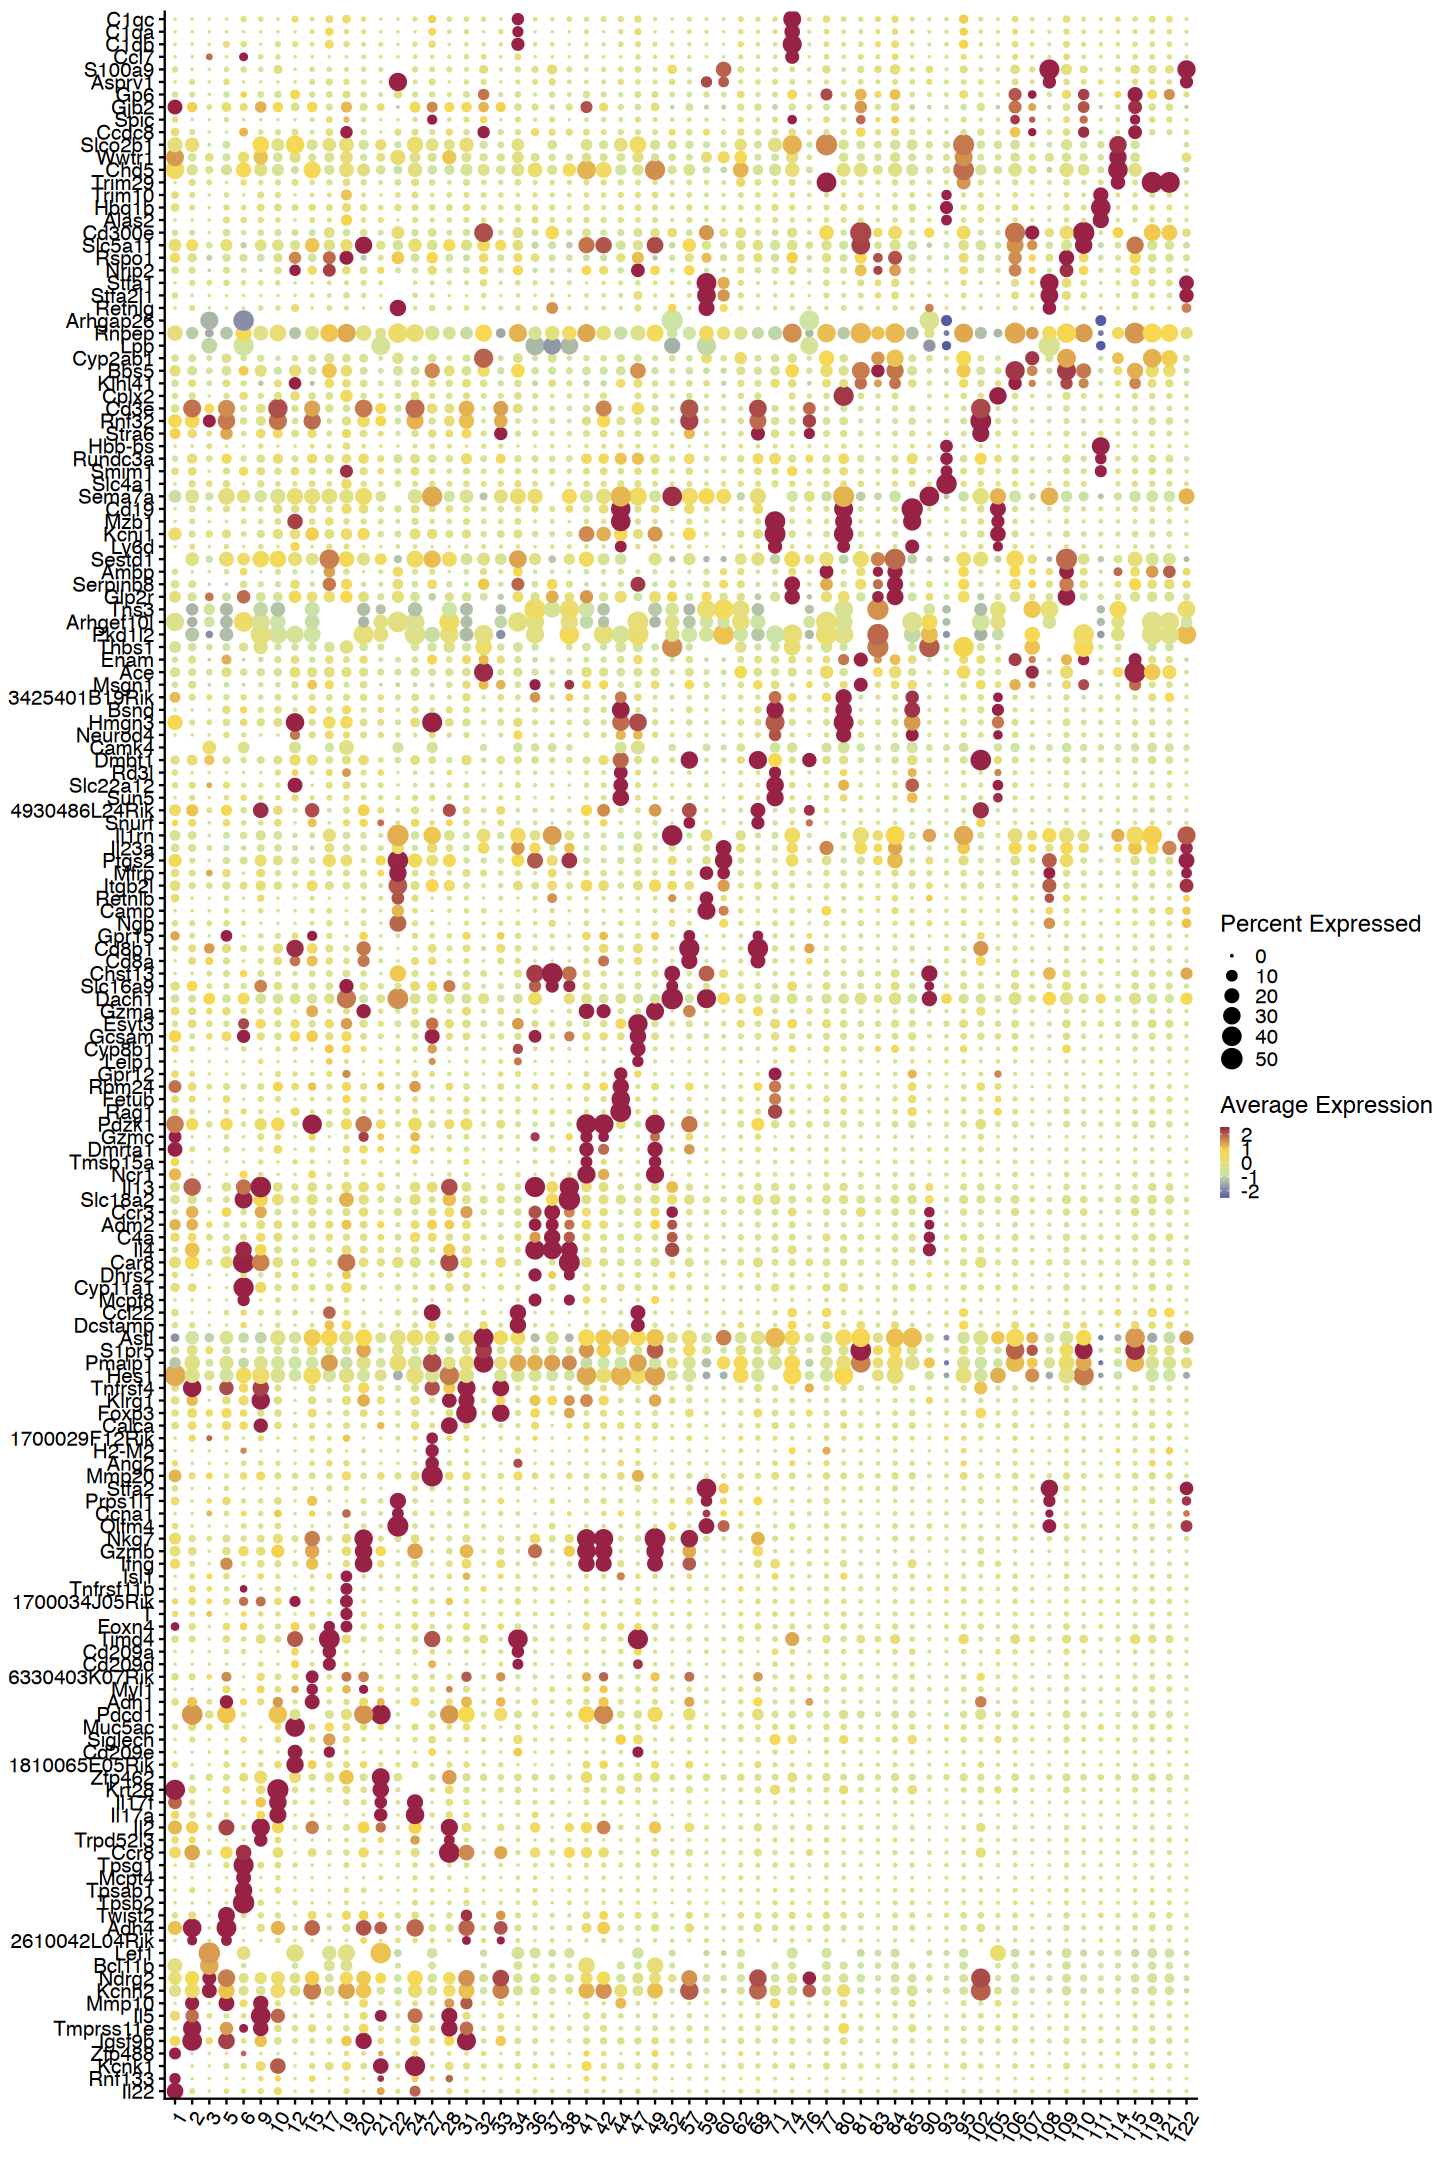

In [ ]:

top_peaks = gene_markers %>% 
    dplyr::filter(avg_log2FC >=0.25&p_val_adj <=0.05) %>%
    group_by(cluster) %>% 
    top_n(4,avg_log2FC) %>%
    arrange(cluster, -avg_log2FC)
cluster_order = sort(as.vector(unique(tmp_srt_gene$name_num)))
top_peaks$cluster = factor(top_peaks$cluster, levels=cluster_order)
top_peaks = top_peaks %>% arrange(cluster, -avg_log2FC)
tmp_srt_gene$name_num = factor(tmp_srt_gene$name_num, levels=cluster_order)
options(repr.plot.width=12, repr.plot.height=18)
a=DotPlot(tmp_srt_gene, 
        features = unique(top_peaks$gene),
        group.by='name_num')+
    scale_color_gradientn(colors = c('#565ca2','#cce5a6','#f7d84f','#972245'))+
    scale_size_continuous(range=c(0,5), limits = c(0,50))+
    #coord_flip()+
    theme(panel.grid = element_blank(),
        axis.text.x = element_text(angle = 60, hjust=1,vjust=1),
        axis.title = element_blank(),
        strip.background = element_blank(),
        legend.key.height = unit(3,'mm'),
        legend.key.size =  unit(2,'mm'))+
    coord_flip()
a

In [134]:
ggsave(glue('{output_dir}/Immune_round4_gene_dot.pdf'), 
       a,
       width=10, height=26, units='in', dpi=600, bg='transparent')

## Epithelium

In [142]:
tmp_srt_gene = subset(gene_activate_srt, Celltype_round1=='Epithelium')
tmp_srt_peak = subset(pseudoObj_cells, Celltype_round1=='Epithelium')

Rasterizing points since number of points exceeds 100,000.
To disable this behavior set `raster=FALSE`

Rasterizing points since number of points exceeds 100,000.
To disable this behavior set `raster=FALSE`



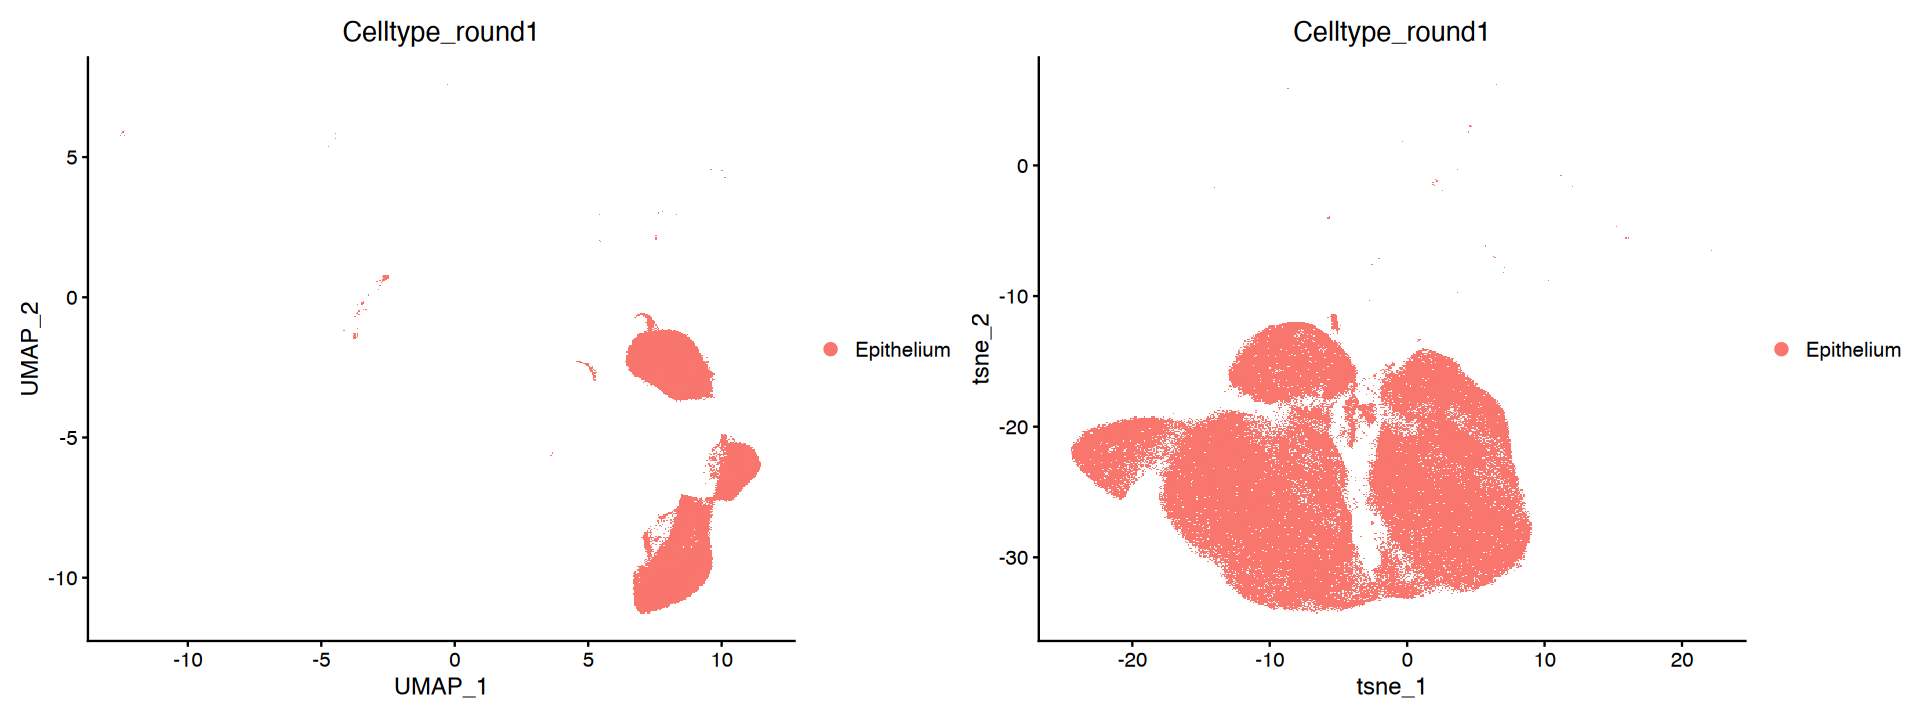

In [10]:
options(repr.plot.width=16, repr.plot.height=6)
a=DimPlot(tmp_srt_peak, reduction = 'umap', group.by = 'Celltype_round1')
b=DimPlot(tmp_srt_peak, reduction = 'tsne', group.by = 'Celltype_round1')
a+b

In [143]:
tmp_umap = read.csv(glue('./placeholder_analysis/round_cluster02/round1/Endothelium/cell_meta.csv'))
rownames(tmp_umap) = tmp_umap$X

In [144]:
tmp_same_bc = intersect(rownames(tmp_umap), colnames(tmp_srt_peak))

In [145]:
length(tmp_same_bc)

[1] 170835

In [146]:
tmp_srt_peak = subset(tmp_srt_peak, cells=tmp_same_bc)
tmp_umap = tmp_umap[tmp_same_bc,]

In [147]:
tmp_srt_peak@meta.data$UMAP_1 = NULL
tmp_srt_peak@meta.data$UMAP_2 = NULL

In [148]:
tmp_srt_peak[['umap']] <- CreateDimReducObject(
  embeddings = as.matrix(tmp_umap[colnames(tmp_srt_peak),c('UMAP_1','UMAP_2')]),
  key = "UMAP_",
  assay = DefaultAssay(tmp_srt_peak)
)
tmp_srt_peak[['tsne']] <- CreateDimReducObject(
  embeddings = as.matrix(tmp_umap[colnames(tmp_srt_peak),c('TSNE_1','TSNE_2')]),
  key = "TSNE_",
  assay = DefaultAssay(tmp_srt_peak)
)

In [149]:
round4_color = readRDS('./placeholder_analysis/round_cluster02/merge/round4_color.rds')
round4_num = readRDS('./placeholder_analysis/round_cluster02/merge/round4_cluster_num.rds')
round4_color2 = round4_color
names(round4_color2) = round4_num[names(round4_color2)]

names(round4_color) = new_celltype[names(round4_color), 'new_name']

tmp_srt_peak$new_name = as.vector(new_celltype[as.vector(tmp_srt_peak$Celltype_round4), 'new_name'])
tmp_srt_peak$name_num = as.vector(new_celltype[as.vector(tmp_srt_peak$Celltype_round4), 'cluster_num'])
tmp_srt_gene$new_name = as.vector(new_celltype[as.vector(tmp_srt_gene$Celltype_round4), 'new_name'])
tmp_srt_gene$name_num = as.vector(new_celltype[as.vector(tmp_srt_gene$Celltype_round4), 'cluster_num'])

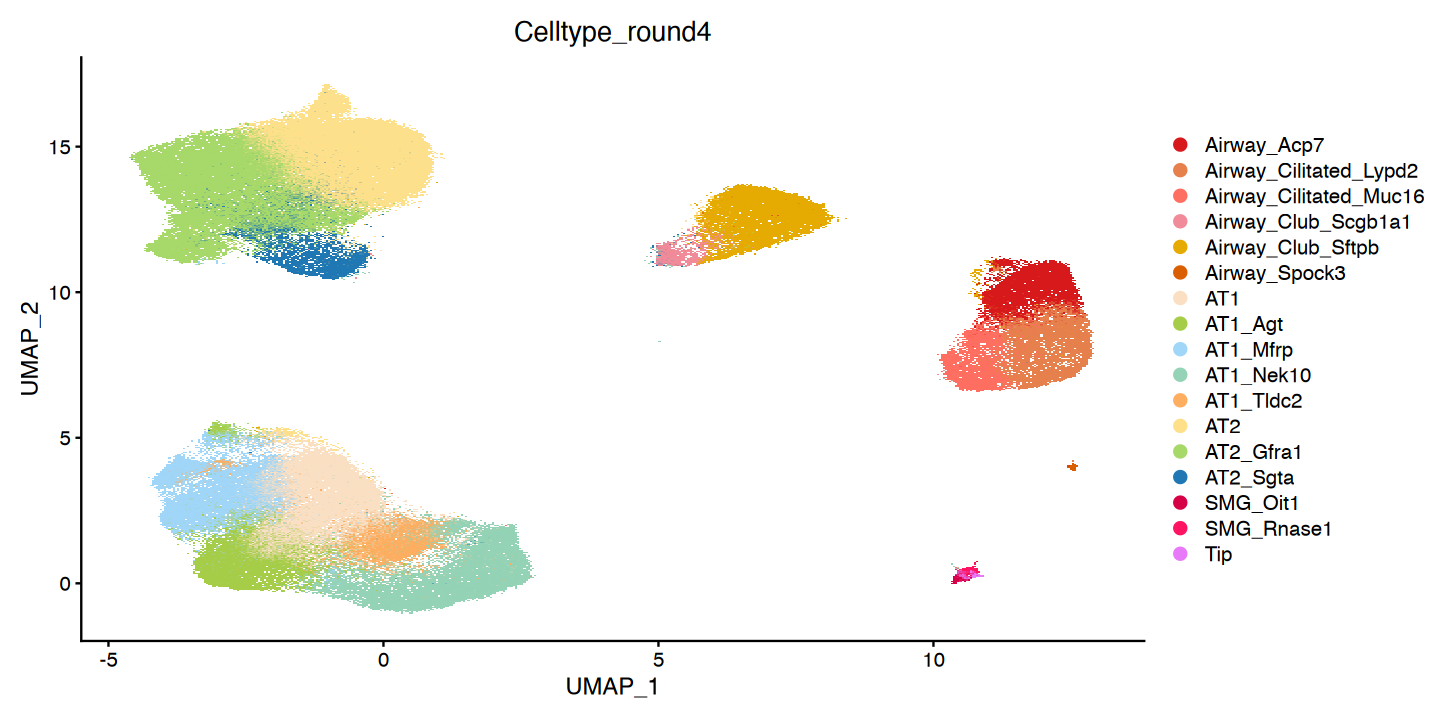

In [24]:
options(repr.plot.width=12, repr.plot.height=6)
a=DimPlot(tmp_srt_peak, reduction = 'umap', group.by = 'Celltype_round4', raster = T)+
    scale_colour_manual(values = round4_color)
#b=DimPlot(tmp_srt_peak, reduction = 'tsne', group.by = 'Celltype_round2', raster = T)
a

In [25]:
ggsave(glue('{output_dir}/Epi_round4_umap.pdf'), 
       a,
       width=8, height=6, units='in', dpi=600, bg='transparent')

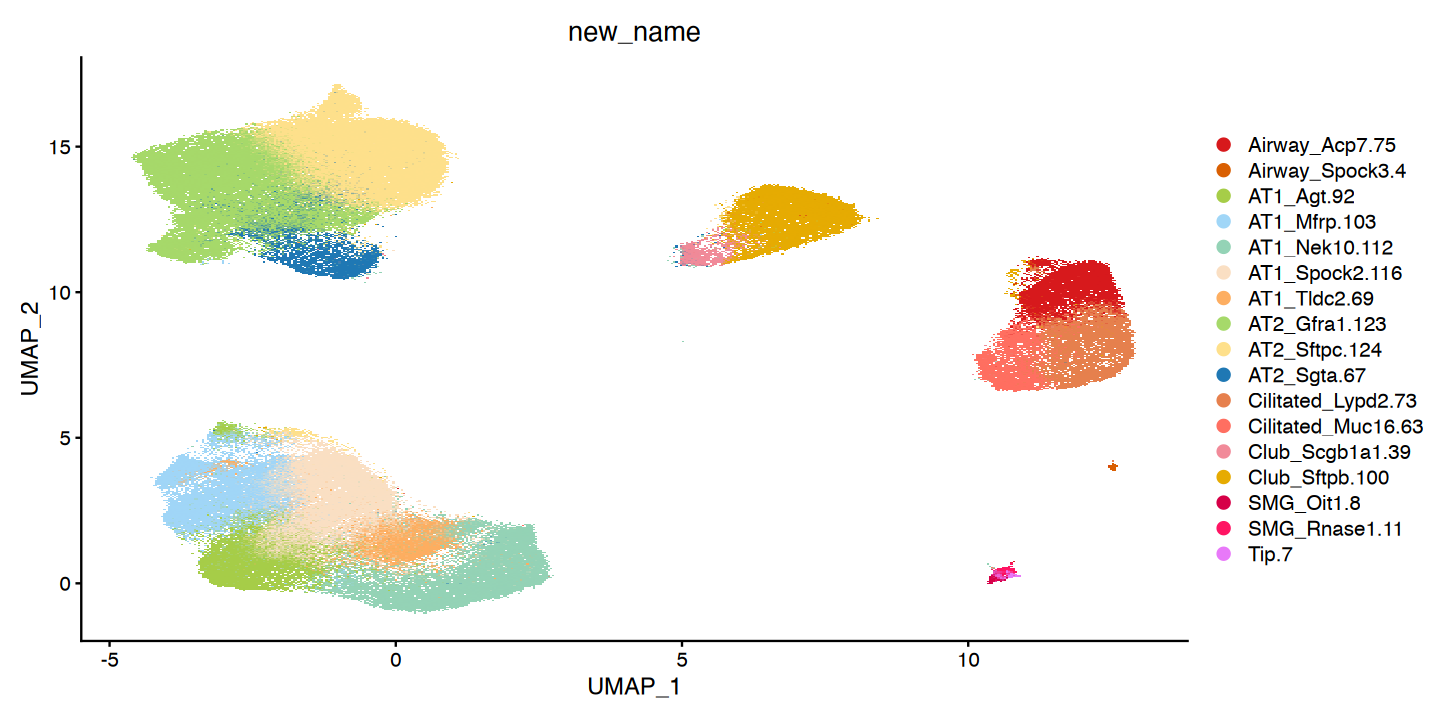

In [150]:
options(repr.plot.width=12, repr.plot.height=6)
a=DimPlot(tmp_srt_peak, reduction = 'umap', group.by = 'new_name', raster = T)+
    scale_colour_manual(values = round4_color)
#b=DimPlot(tmp_srt_peak, reduction = 'tsne', group.by = 'Celltype_round2', raster = T)
a
ggsave(glue('{output_dir}/Epi_round4_umap.pdf'), 
       a,
       width=8, height=6, units='in', dpi=600, bg='transparent')

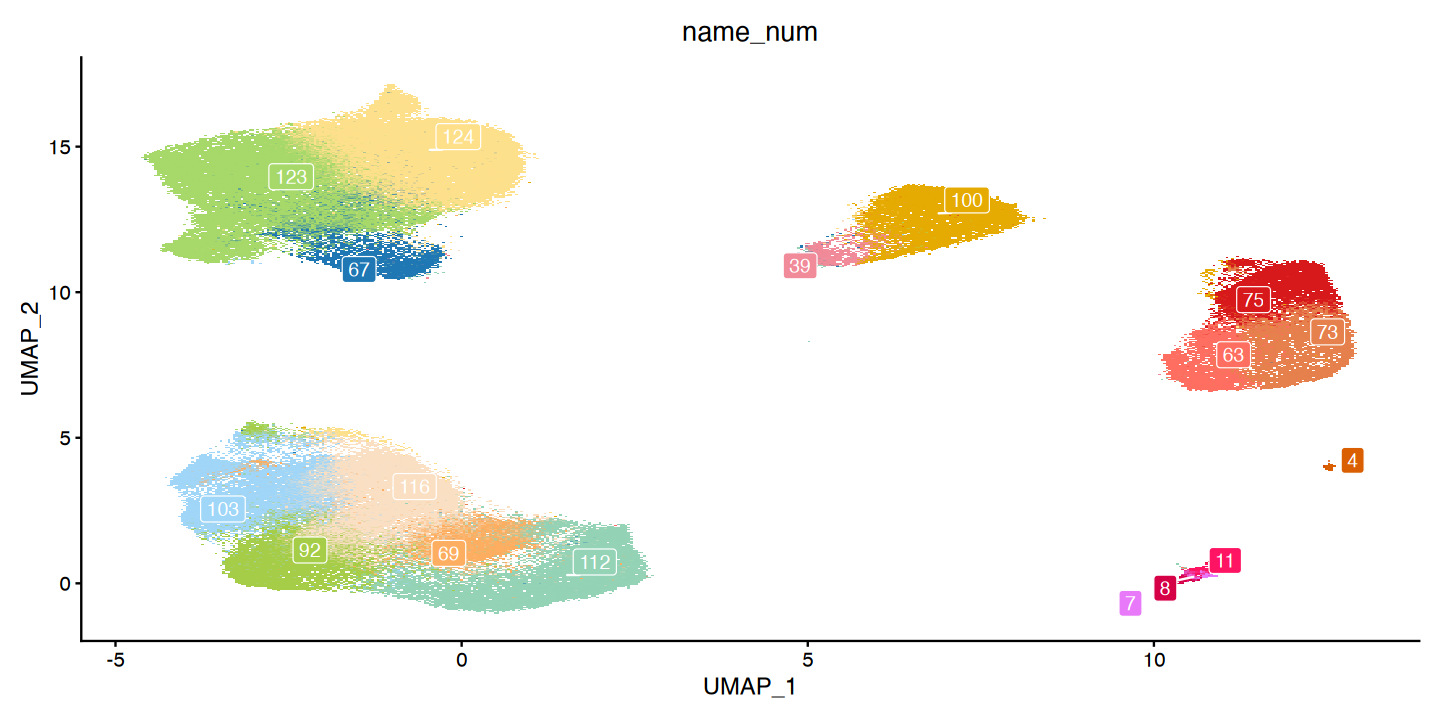

In [ ]:

options(repr.plot.width=12, repr.plot.height=6)
a=DimPlot(tmp_srt_peak, reduction = 'umap', group.by = 'name_num',
     raster = T, label = T, label.box=T,repel=T,label.color = "white", #alpha=0.5,
     cols=round4_color2)+NoLegend()
#b=DimPlot(tmp_srt_peak, reduction = 'tsne', group.by = 'Celltype_round2', raster = T)
a
ggsave(glue('{output_dir}/Epi_round4_umap(label).pdf'), 
       a,
       width=6, height=6, units='in', dpi=600, bg='transparent')

In [152]:
tmp_srt_gene <- NormalizeData(tmp_srt_gene, normalization.method = "LogNormalize", scale.factor = 10000)
tmp_srt_gene <- FindVariableFeatures(tmp_srt_gene, selection.method = "vst", nfeatures = 2000)
all.genes <- rownames(tmp_srt_gene)
tmp_srt_gene <- ScaleData(tmp_srt_gene, features = all.genes)
tmp_srt_gene

Normalizing layer: counts

Finding variable features for layer counts

Centering and scaling data matrix



An object of class Seurat 
17034 features across 85311 samples within 1 assay 
Active assay: RNA (17034 features, 2000 variable features)
 3 layers present: counts, data, scale.data
 2 dimensional reductions calculated: umap, tsne

In [27]:
Idents(tmp_srt_gene) = tmp_srt_gene$Celltype_round4
gene_markers = FindAllMarkers(tmp_srt_gene, max.cells.per.ident = 300)

Calculating cluster AT2

Calculating cluster Airway_Club_Sftpb

Calculating cluster AT1_Tldc2

Calculating cluster AT1_Nek10

Calculating cluster AT1_Agt

Calculating cluster Airway_Cilitated_Muc16

Calculating cluster AT1

Calculating cluster AT2_Gfra1

Calculating cluster Airway_Acp7

Calculating cluster AT2_Sgta

Calculating cluster AT1_Mfrp

Calculating cluster Airway_Cilitated_Lypd2

Calculating cluster SMG_Oit1

Calculating cluster Airway_Club_Scgb1a1

Calculating cluster SMG_Rnase1

Calculating cluster Airway_Spock3

Calculating cluster Tip



In [28]:
write.table(gene_markers, 
            file=glue('{output_dir}/Epi_round4_gene_markers.txt'),
            sep='\t', quote=F, row.names=F)

Scale for colour is already present.
Adding another scale for colour, which will replace the existing scale.
Scale for size is already present.
Adding another scale for size, which will replace the existing scale.


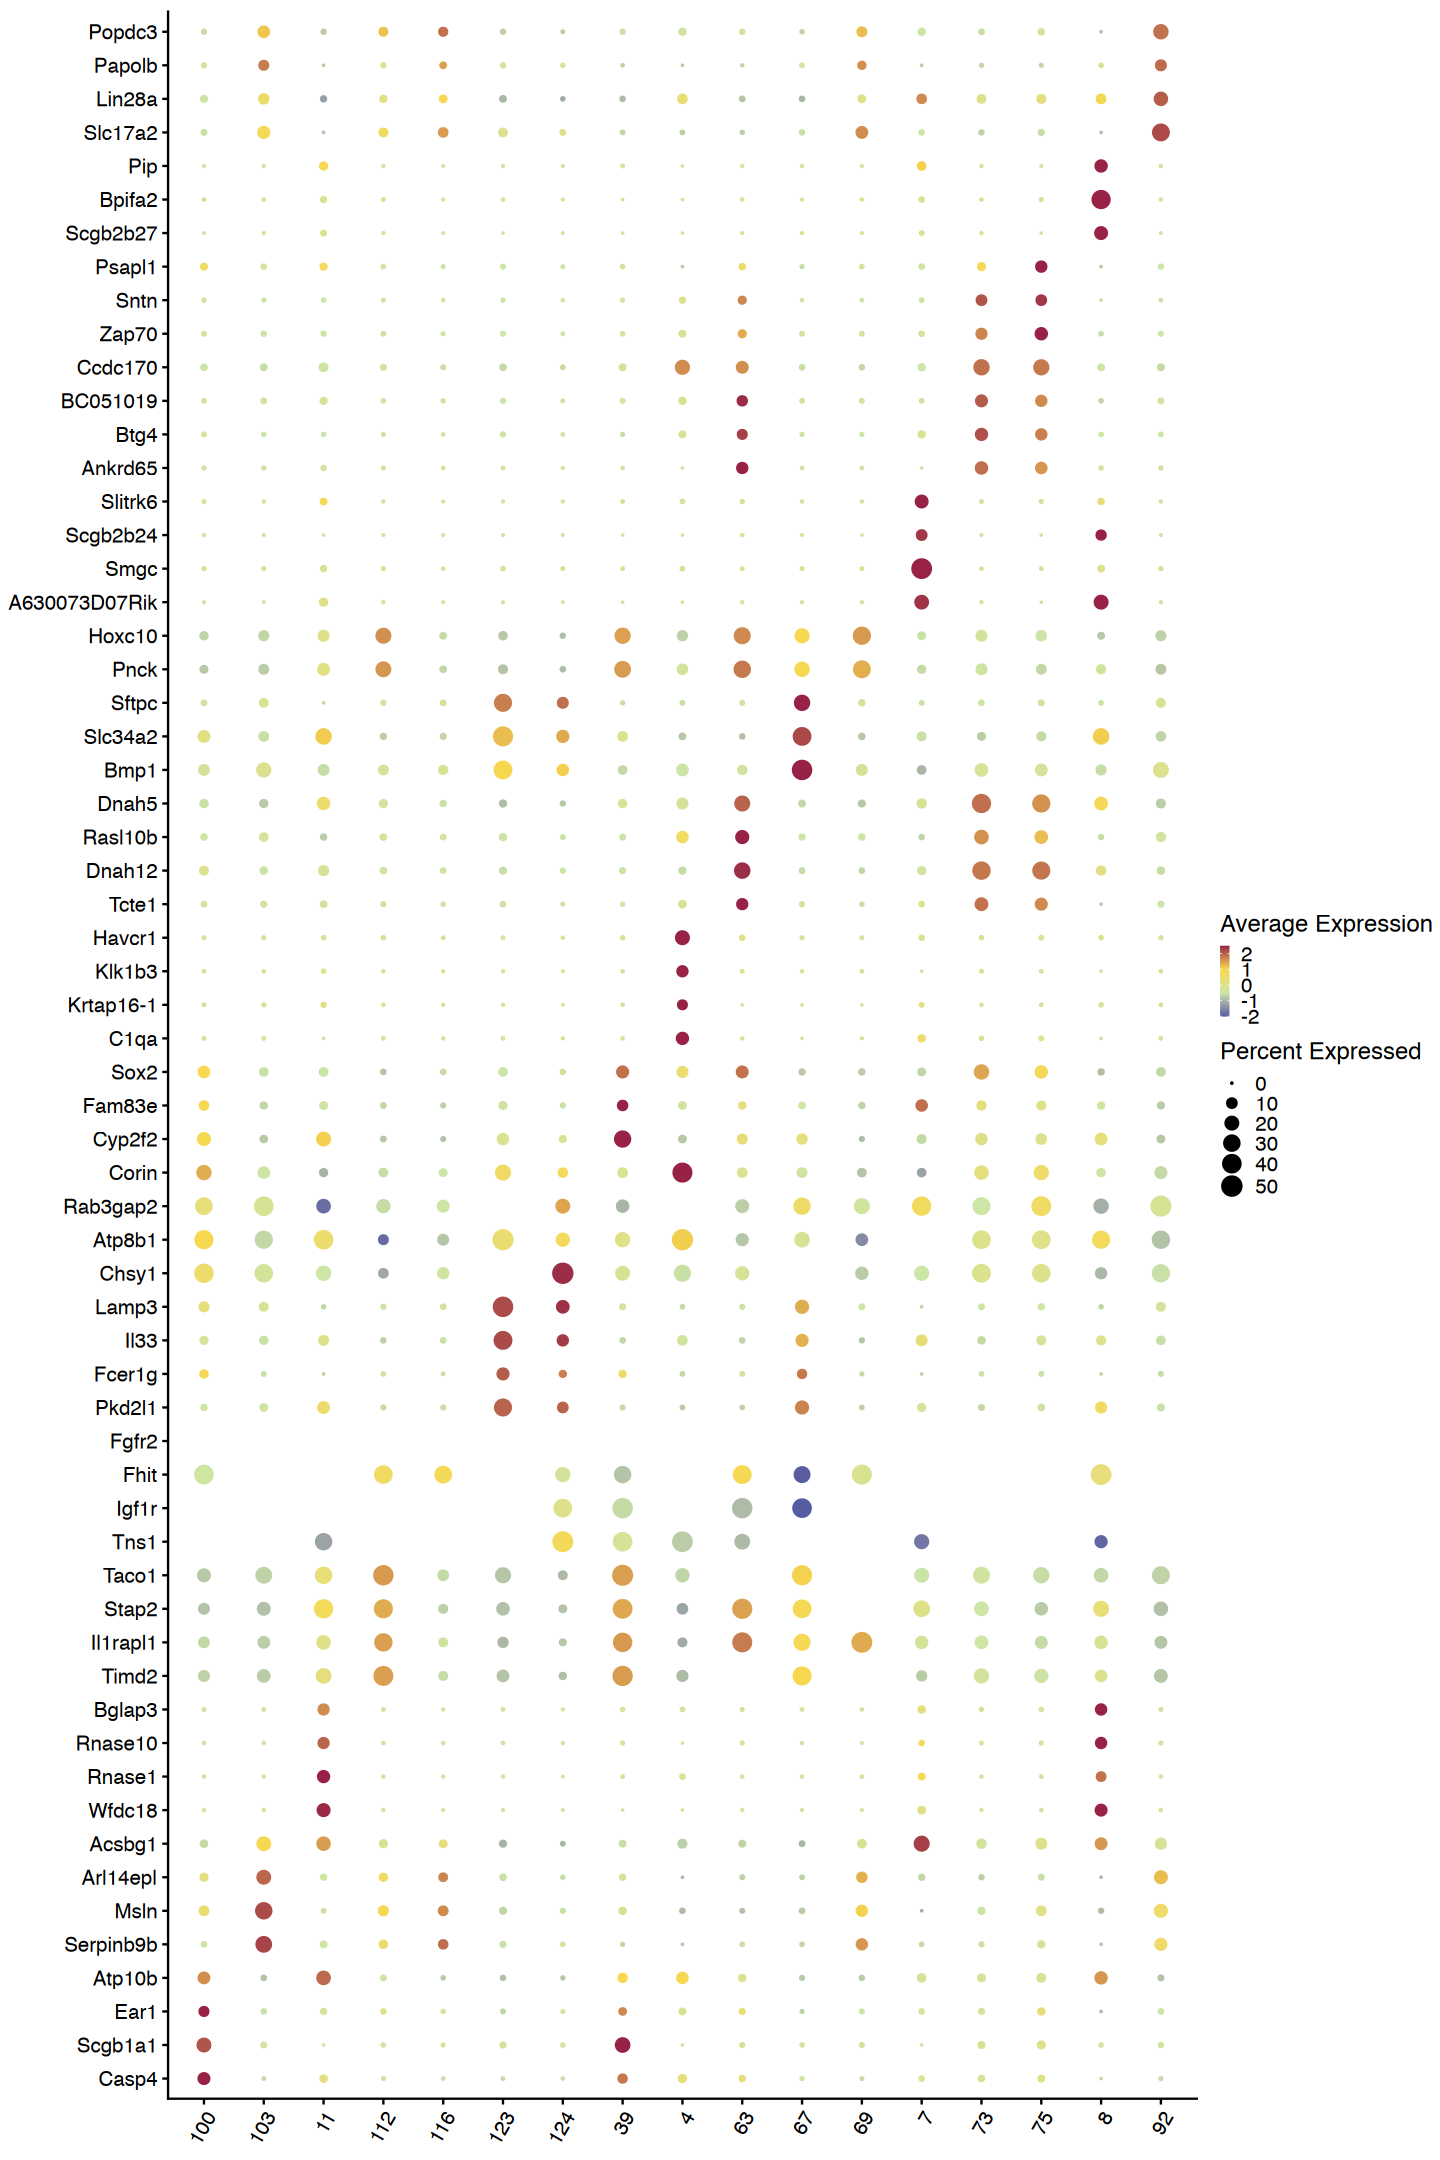

In [155]:
gene_markers = read.table(glue('{output_dir}/Epi_round4_gene_markers.txt'), header = T)
gene_markers$cluster = new_celltype[gene_markers$cluster, 'cluster_num']

top_peaks = gene_markers %>% 
    dplyr::filter(avg_log2FC >=0.25&p_val_adj <=0.05) %>%
    group_by(cluster) %>% 
    top_n(4,avg_log2FC) %>%
    arrange(cluster, -avg_log2FC)
cluster_order = sort(as.vector(unique(tmp_srt_gene$name_num)))
top_peaks$cluster = factor(top_peaks$cluster, levels=cluster_order)
top_peaks = top_peaks %>% arrange(cluster, -avg_log2FC)
tmp_srt_gene$name_num = factor(tmp_srt_gene$name_num, levels=cluster_order)
options(repr.plot.width=12, repr.plot.height=18)
a=DotPlot(tmp_srt_gene, 
        features = unique(top_peaks$gene),
        group.by='name_num')+
    scale_color_gradientn(colors = c('#565ca2','#cce5a6','#f7d84f','#972245'))+
    scale_size_continuous(range=c(0,5), limits = c(0,50))+
    #coord_flip()+
    theme(panel.grid = element_blank(),
        axis.text.x = element_text(angle = 60, hjust=1,vjust=1),
        axis.title = element_blank(),
        strip.background = element_blank(),
        legend.key.height = unit(3,'mm'),
        legend.key.size =  unit(2,'mm'))+
    coord_flip()
a

In [158]:
ggsave(glue('{output_dir}/Epithelial_round4_gene_dot.pdf'), 
       a,
       width=7, height=12, units='in', dpi=600, bg='transparent')

## Stromal

In [159]:
tmp_srt_gene = subset(gene_activate_srt, Celltype_round1=='Stroma')
tmp_srt_peak = subset(pseudoObj_cells, Celltype_round1=='Stroma')

Rasterizing points since number of points exceeds 100,000.
To disable this behavior set `raster=FALSE`

Rasterizing points since number of points exceeds 100,000.
To disable this behavior set `raster=FALSE`



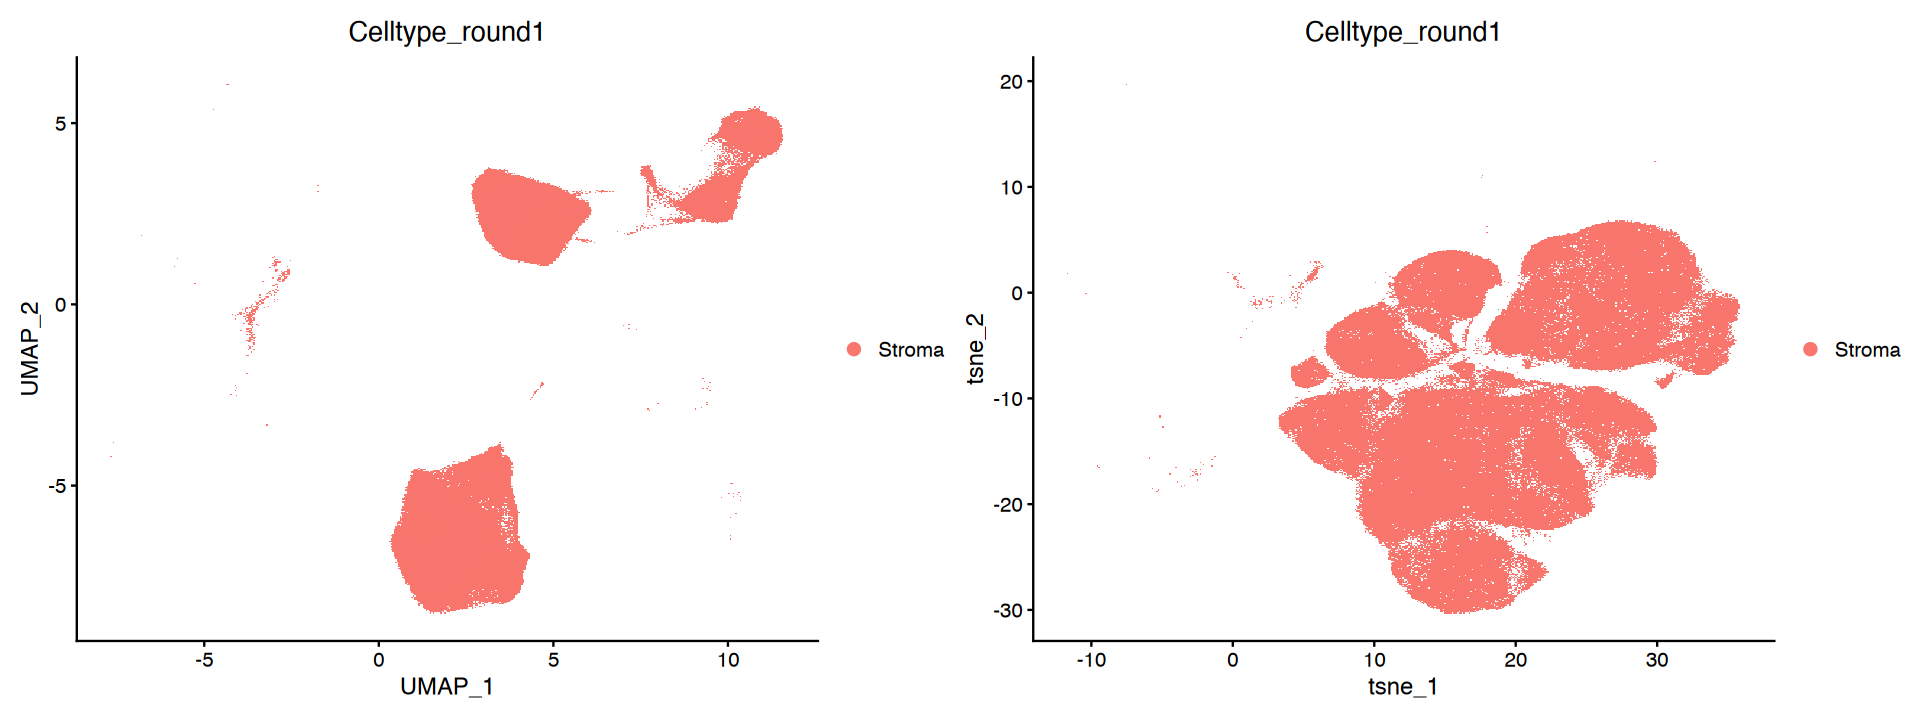

In [36]:
options(repr.plot.width=16, repr.plot.height=6)
a=DimPlot(tmp_srt_peak, reduction = 'umap', group.by = 'Celltype_round1')
b=DimPlot(tmp_srt_peak, reduction = 'tsne', group.by = 'Celltype_round1')
a+b

In [160]:
tmp_umap = read.csv(glue('./placeholder_analysis/round_cluster02/round1/Stroma/cell_meta.csv'))
rownames(tmp_umap) = tmp_umap$X

In [161]:
tmp_same_bc = intersect(rownames(tmp_umap), colnames(tmp_srt_peak))

In [162]:
length(tmp_same_bc)

[1] 262996

In [163]:
tmp_srt_peak = subset(tmp_srt_peak, cells=tmp_same_bc)
tmp_umap = tmp_umap[tmp_same_bc,]

In [164]:
tmp_srt_peak@meta.data$UMAP_1 = NULL
tmp_srt_peak@meta.data$UMAP_2 = NULL

In [165]:
tmp_srt_peak[['umap']] <- CreateDimReducObject(
  embeddings = as.matrix(tmp_umap[colnames(tmp_srt_peak),c('UMAP_1','UMAP_2')]),
  key = "UMAP_",
  assay = DefaultAssay(tmp_srt_peak)
)
tmp_srt_peak[['tsne']] <- CreateDimReducObject(
  embeddings = as.matrix(tmp_umap[colnames(tmp_srt_peak),c('TSNE_1','TSNE_2')]),
  key = "TSNE_",
  assay = DefaultAssay(tmp_srt_peak)
)

In [166]:
round4_color = readRDS('./placeholder_analysis/round_cluster02/merge/round4_color.rds')
round4_num = readRDS('./placeholder_analysis/round_cluster02/merge/round4_cluster_num.rds')
round4_color2 = round4_color
names(round4_color2) = round4_num[names(round4_color2)]

names(round4_color) = new_celltype[names(round4_color), 'new_name']

tmp_srt_peak$new_name = as.vector(new_celltype[as.vector(tmp_srt_peak$Celltype_round4), 'new_name'])
tmp_srt_peak$name_num = as.vector(new_celltype[as.vector(tmp_srt_peak$Celltype_round4), 'cluster_num'])
tmp_srt_gene$new_name = as.vector(new_celltype[as.vector(tmp_srt_gene$Celltype_round4), 'new_name'])
tmp_srt_gene$name_num = as.vector(new_celltype[as.vector(tmp_srt_gene$Celltype_round4), 'cluster_num'])

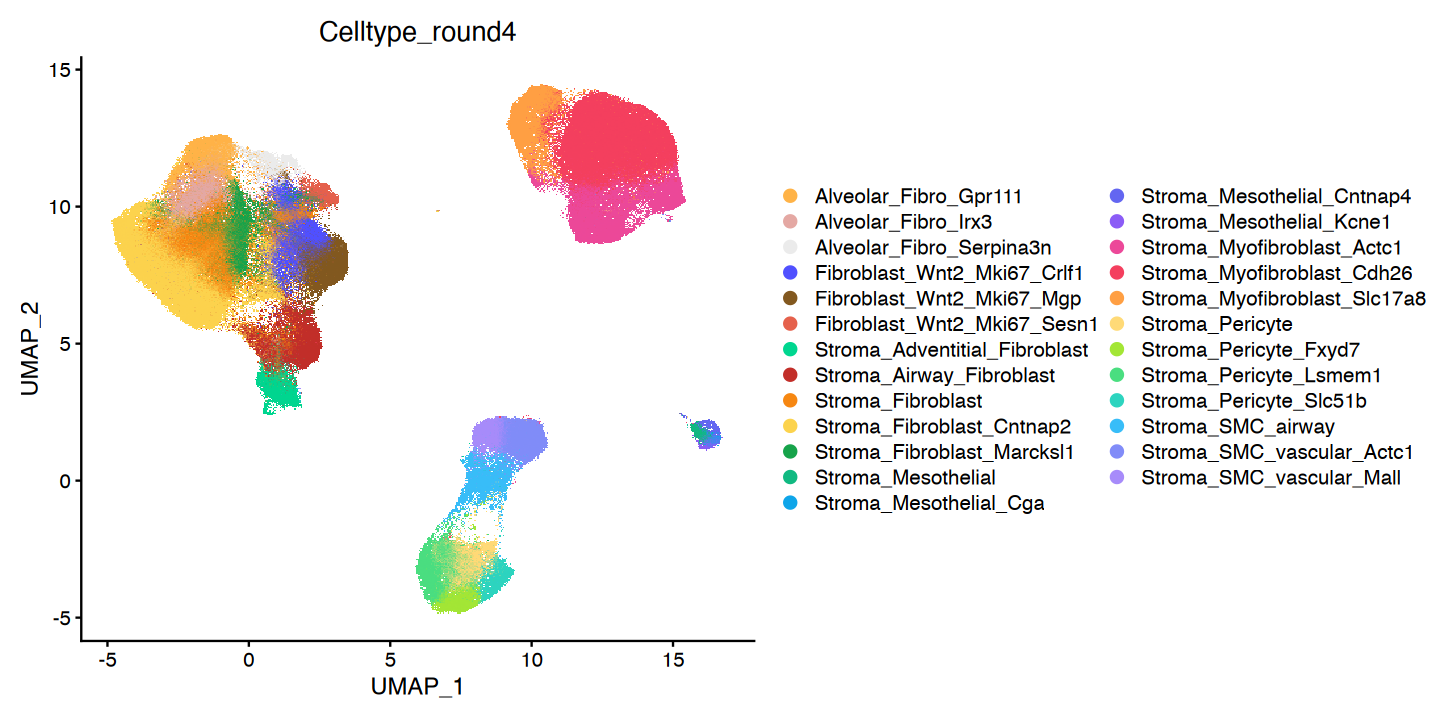

In [44]:
options(repr.plot.width=12, repr.plot.height=6)
a=DimPlot(tmp_srt_peak, reduction = 'umap', group.by = 'Celltype_round4', raster = T)+
    scale_colour_manual(values = round4_color)
#b=DimPlot(tmp_srt_peak, reduction = 'tsne', group.by = 'Celltype_round2', raster = T)
a

In [46]:
ggsave(glue('{output_dir}/Stroma_round4_umap.pdf'), 
       a,
       width=12, height=6, units='in', dpi=600, bg='transparent')

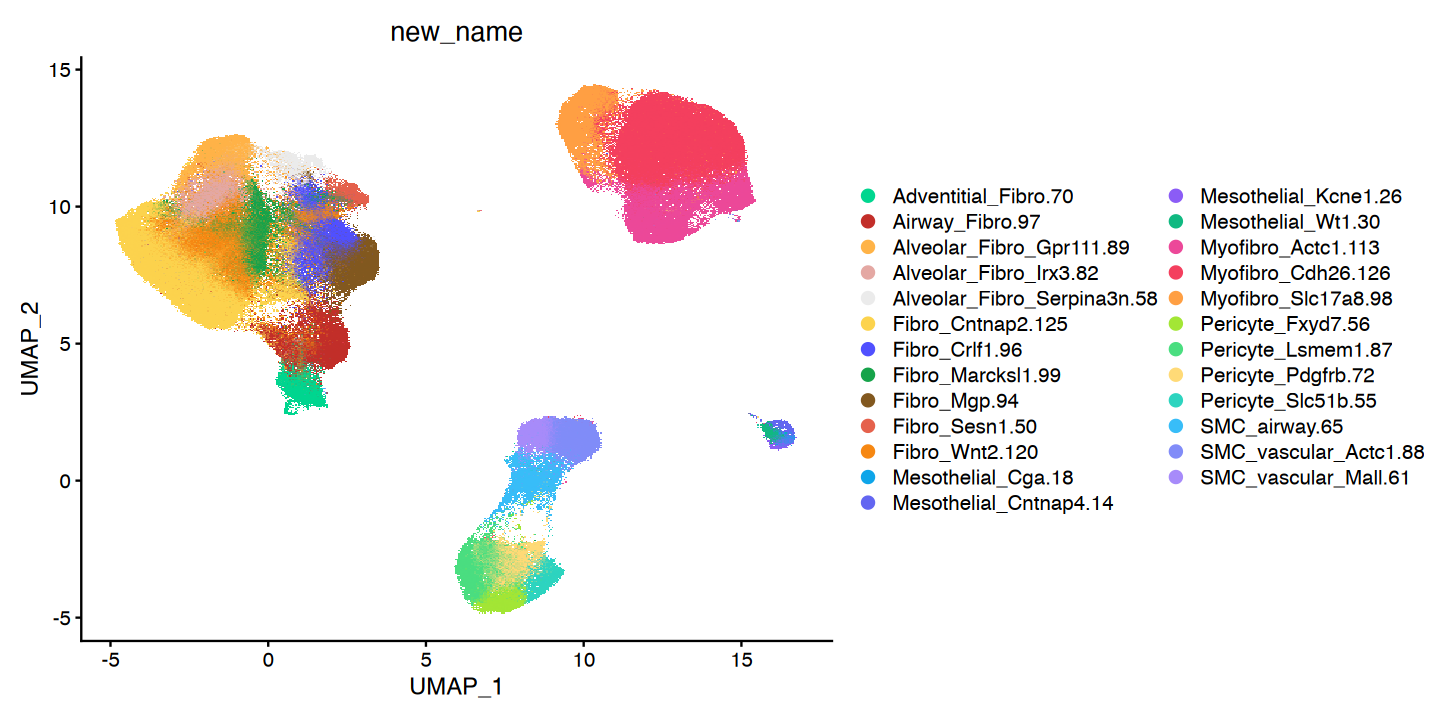

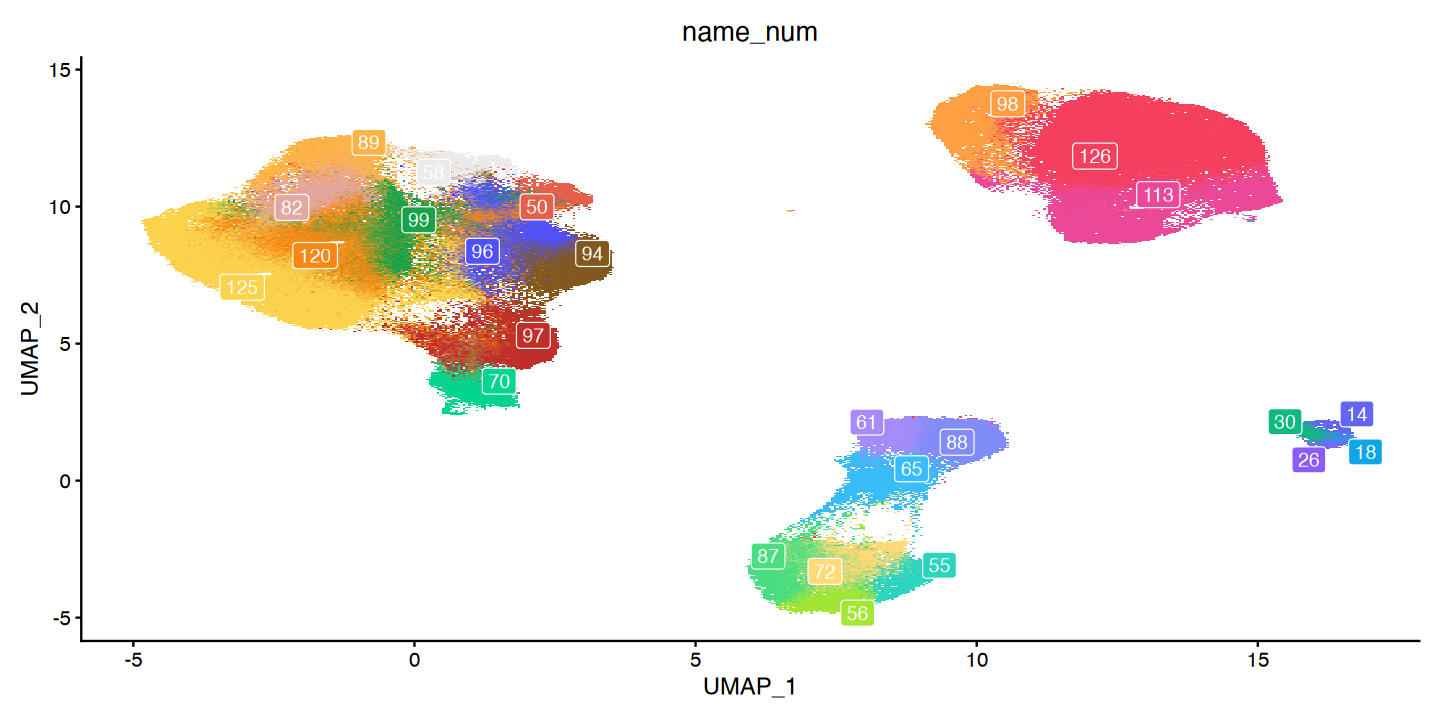

In [167]:
options(repr.plot.width=12, repr.plot.height=6)
a=DimPlot(tmp_srt_peak, reduction = 'umap', group.by = 'new_name', raster = T)+
    scale_colour_manual(values = round4_color)
#b=DimPlot(tmp_srt_peak, reduction = 'tsne', group.by = 'Celltype_round2', raster = T)
a
ggsave(glue('{output_dir}/Stroma_round4_umap.pdf'), 
       a,
       width=8, height=6, units='in', dpi=600, bg='transparent')
options(repr.plot.width=12, repr.plot.height=6)
a=DimPlot(tmp_srt_peak, reduction = 'umap', group.by = 'name_num',
     raster = T, label = T, label.box=T,repel=T,label.color = "white", #alpha=0.5,
     cols=round4_color2)+NoLegend()
#b=DimPlot(tmp_srt_peak, reduction = 'tsne', group.by = 'Celltype_round2', raster = T)
a
ggsave(glue('{output_dir}/Stroma_round4_umap(label).pdf'), 
       a,
       width=6, height=6, units='in', dpi=600, bg='transparent')

In [168]:
tmp_srt_gene <- NormalizeData(tmp_srt_gene, normalization.method = "LogNormalize", scale.factor = 10000)
tmp_srt_gene <- FindVariableFeatures(tmp_srt_gene, selection.method = "vst", nfeatures = 2000)
all.genes <- rownames(tmp_srt_gene)
tmp_srt_gene <- ScaleData(tmp_srt_gene, features = all.genes)
tmp_srt_gene

Normalizing layer: counts

Finding variable features for layer counts

Centering and scaling data matrix



An object of class Seurat 
17034 features across 131481 samples within 1 assay 
Active assay: RNA (17034 features, 2000 variable features)
 3 layers present: counts, data, scale.data
 2 dimensional reductions calculated: umap, tsne

In [48]:
Idents(tmp_srt_gene) = tmp_srt_gene$Celltype_round4
gene_markers = FindAllMarkers(tmp_srt_gene, max.cells.per.ident = 300)

Calculating cluster Stroma_SMC_vascular_Actc1

Calculating cluster Stroma_Myofibroblast_Cdh26

Calculating cluster Stroma_Fibroblast

Calculating cluster Fibroblast_Wnt2_Mki67_Crlf1

Calculating cluster Alveolar_Fibro_Serpina3n

Calculating cluster Alveolar_Fibro_Irx3

Calculating cluster Stroma_Myofibroblast_Actc1

Calculating cluster Stroma_Myofibroblast_Slc17a8

Calculating cluster Stroma_Pericyte

Calculating cluster Stroma_SMC_airway

Calculating cluster Alveolar_Fibro_Gpr111

Calculating cluster Stroma_Airway_Fibroblast

Calculating cluster Stroma_Fibroblast_Cntnap2

Calculating cluster Stroma_Pericyte_Slc51b

Calculating cluster Fibroblast_Wnt2_Mki67_Mgp

Calculating cluster Stroma_Pericyte_Lsmem1

Calculating cluster Stroma_Adventitial_Fibroblast

Calculating cluster Stroma_Pericyte_Fxyd7

Calculating cluster Stroma_Fibroblast_Marcksl1

Calculating cluster Fibroblast_Wnt2_Mki67_Sesn1

Calculating cluster Stroma_SMC_vascular_Mall

Calculating cluster Stroma_Mesothelial_Kcne1

Ca

In [49]:
write.table(gene_markers, 
            file=glue('{output_dir}/Stroma_round4_gene_markers.txt'),
            sep='\t', quote=F, row.names=F)

Scale for colour is already present.
Adding another scale for colour, which will replace the existing scale.
Scale for size is already present.
Adding another scale for size, which will replace the existing scale.


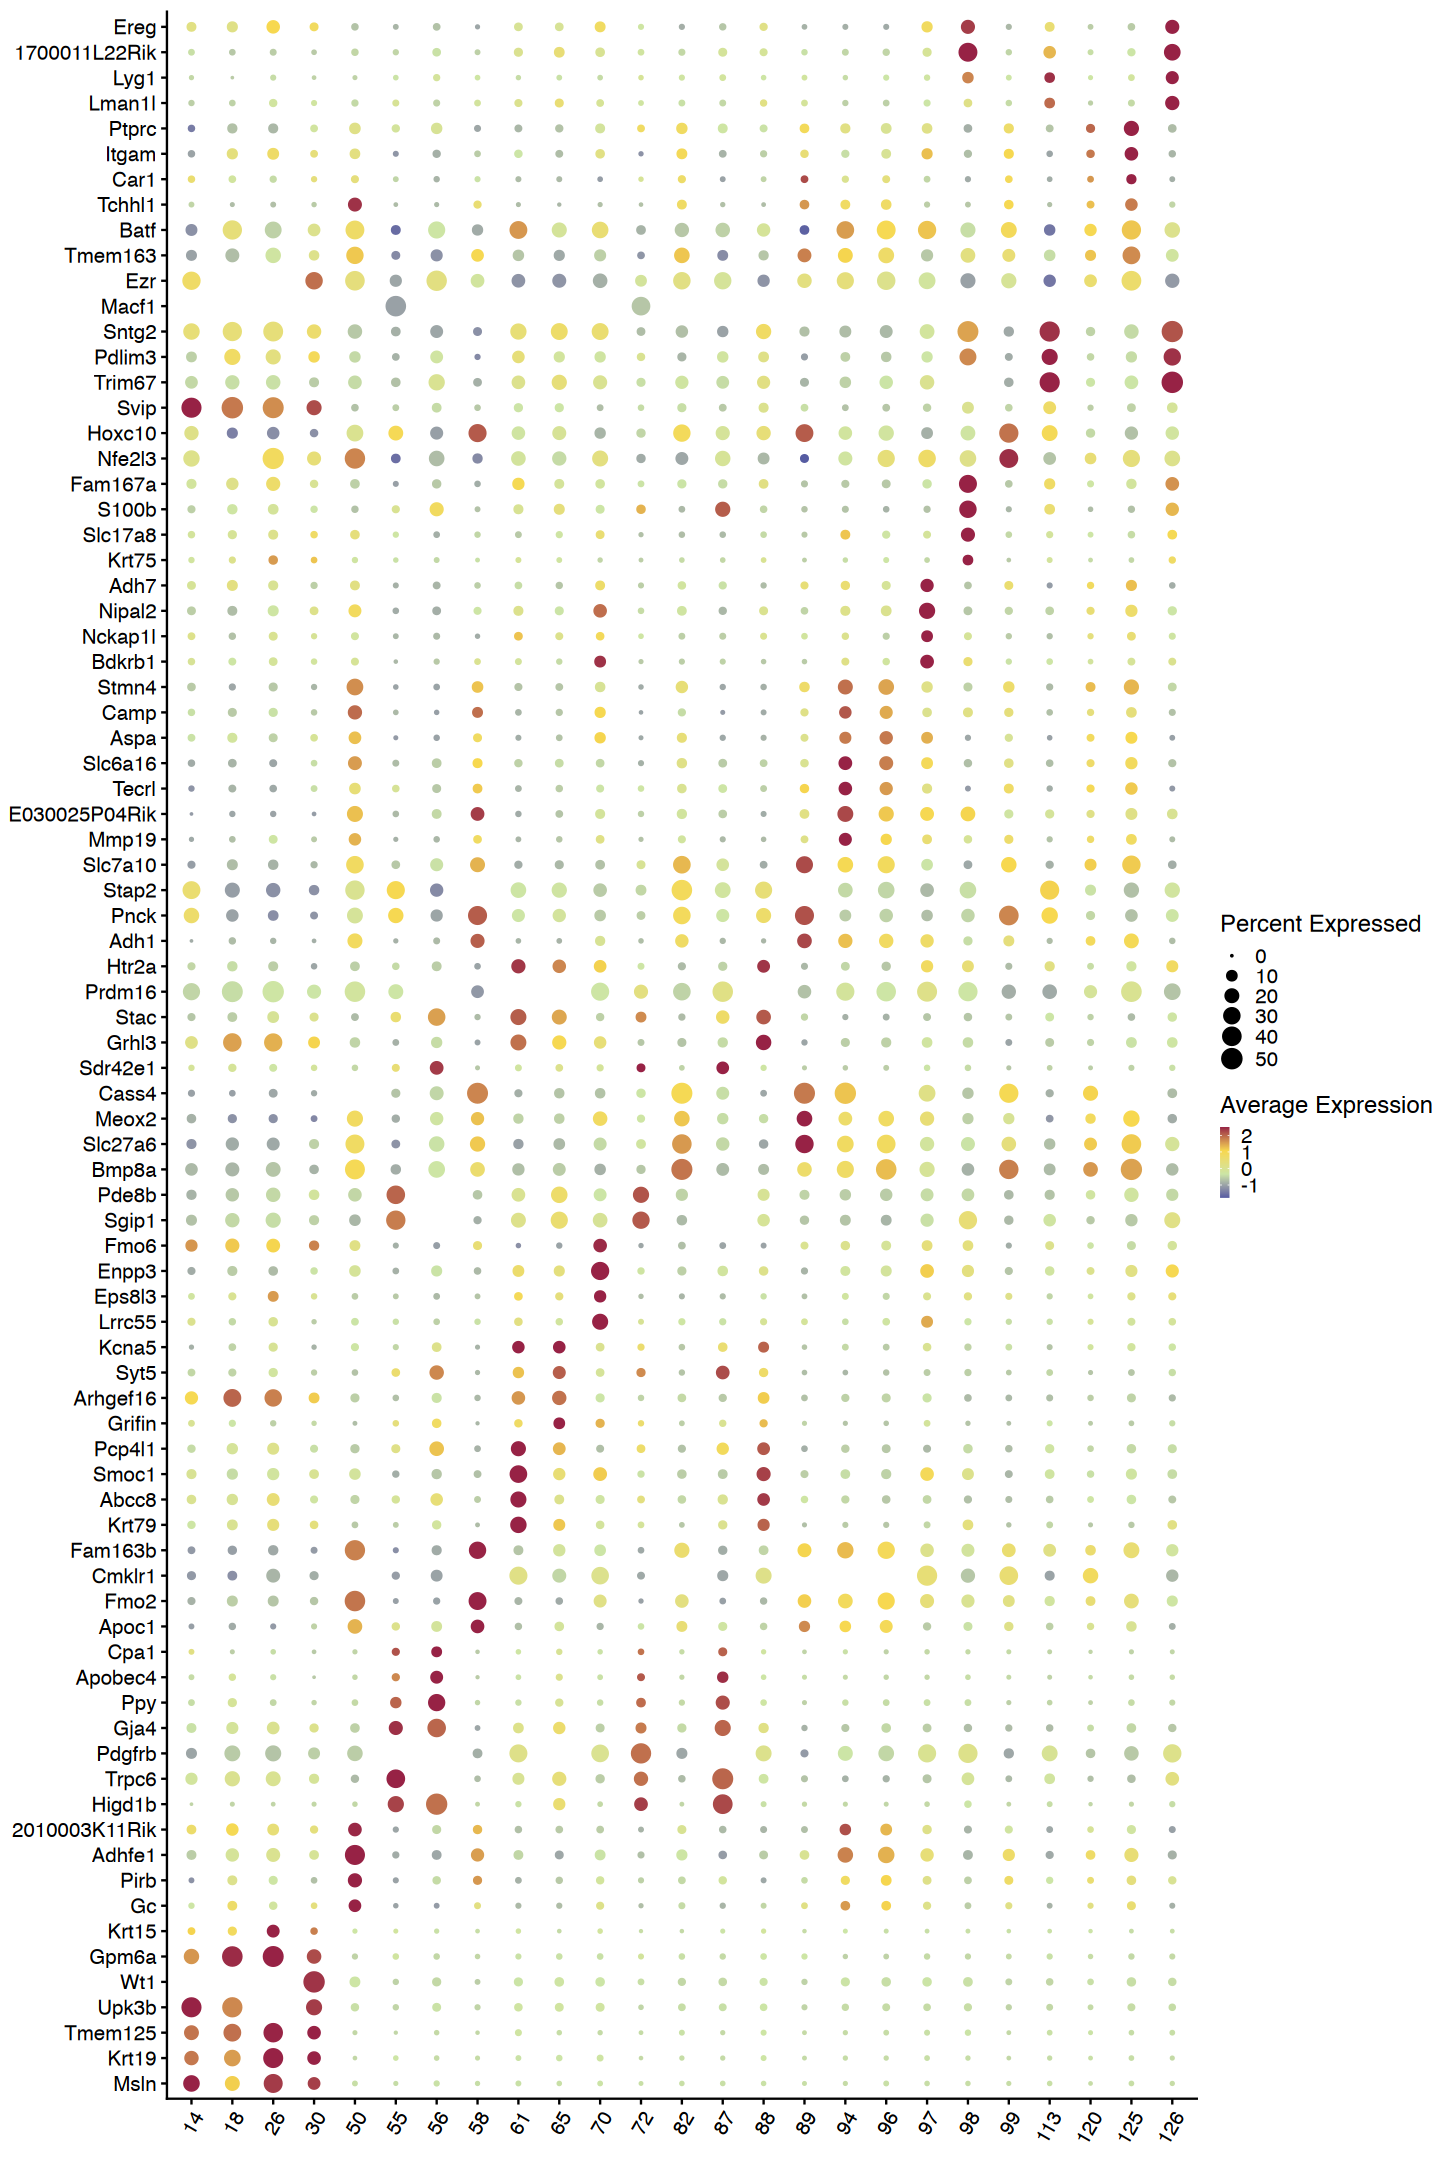

In [169]:
gene_markers = read.table(glue('{output_dir}/Stroma_round4_gene_markers.txt'), header = T)
gene_markers$cluster = new_celltype[gene_markers$cluster, 'cluster_num']

top_peaks = gene_markers %>% 
    dplyr::filter(avg_log2FC >=0.25&p_val_adj <=0.05) %>%
    group_by(cluster) %>% 
    top_n(4,avg_log2FC) %>%
    arrange(cluster, -avg_log2FC)
cluster_order = sort(as.vector(unique(tmp_srt_gene$name_num)))
top_peaks$cluster = factor(top_peaks$cluster, levels=cluster_order)
top_peaks = top_peaks %>% arrange(cluster, -avg_log2FC)
tmp_srt_gene$name_num = factor(tmp_srt_gene$name_num, levels=cluster_order)
options(repr.plot.width=12, repr.plot.height=18)
a=DotPlot(tmp_srt_gene, 
        features = unique(top_peaks$gene),
        group.by='name_num')+
    scale_color_gradientn(colors = c('#565ca2','#cce5a6','#f7d84f','#972245'))+
    scale_size_continuous(range=c(0,5), limits = c(0,50))+
    #coord_flip()+
    theme(panel.grid = element_blank(),
        axis.text.x = element_text(angle = 60, hjust=1,vjust=1),
        axis.title = element_blank(),
        strip.background = element_blank(),
        legend.key.height = unit(3,'mm'),
        legend.key.size =  unit(2,'mm'))+
    coord_flip()
a

In [170]:
ggsave(glue('{output_dir}/Stroma_round4_gene_dot.pdf'), 
       a,
       width=8, height=14, units='in', dpi=600, bg='transparent')

## Endothelium

In [171]:
tmp_srt_gene = subset(gene_activate_srt, Celltype_round1=='Endothelium')
tmp_srt_peak = subset(pseudoObj_cells, Celltype_round1=='Endothelium')

Rasterizing points since number of points exceeds 100,000.
To disable this behavior set `raster=FALSE`

Rasterizing points since number of points exceeds 100,000.
To disable this behavior set `raster=FALSE`



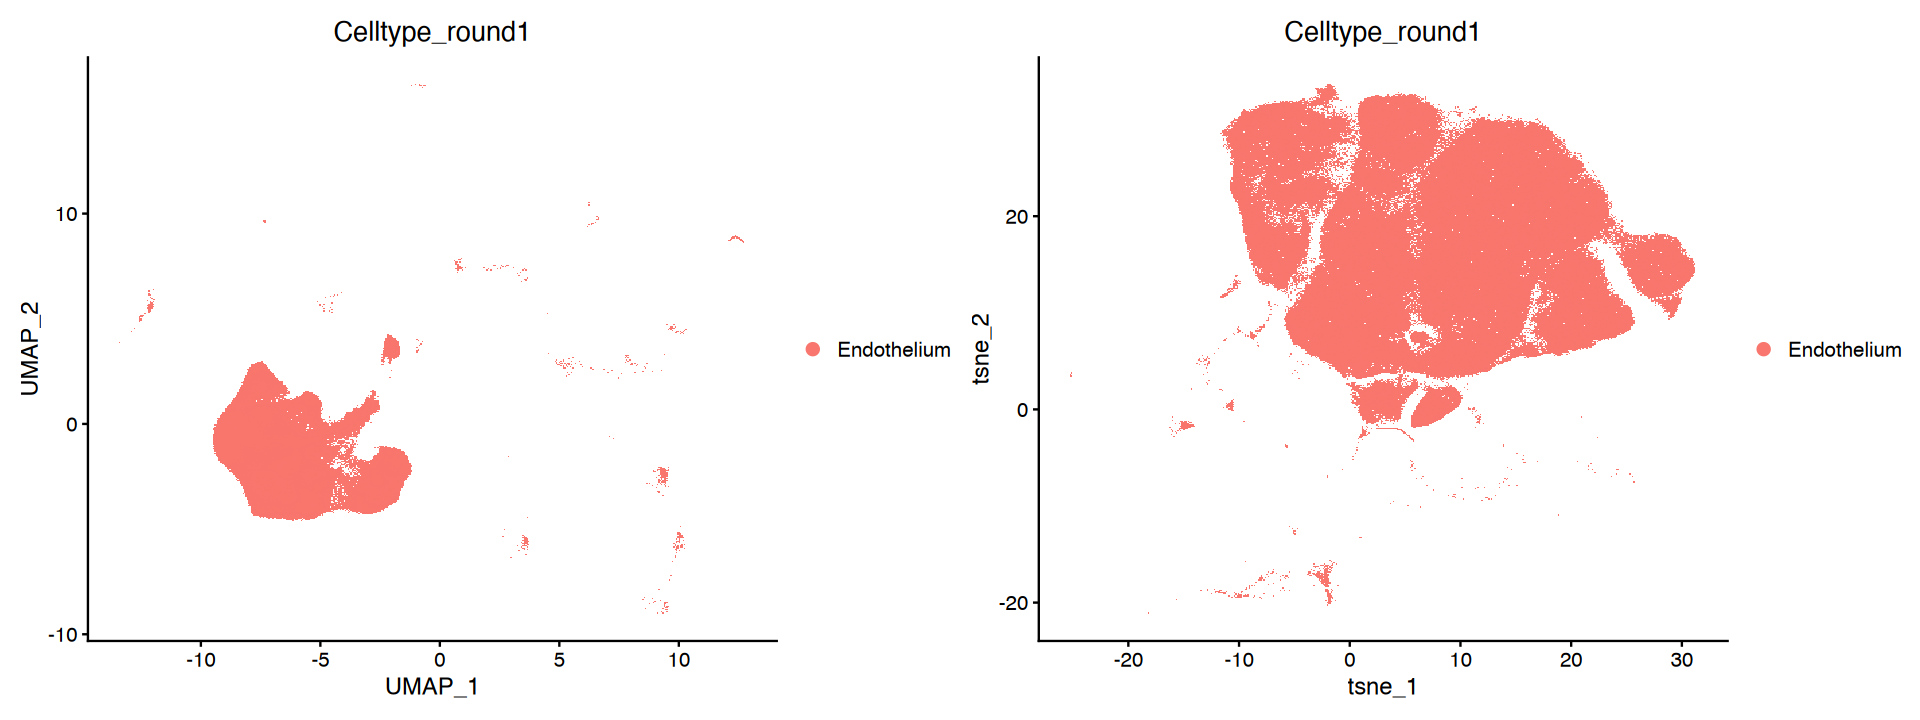

In [ ]:
options(repr.plot.width=16, repr.plot.height=6)
a=DimPlot(tmp_srt_peak, reduction = 'umap', group.by = 'Celltype_round1')
b=DimPlot(tmp_srt_peak, reduction = 'tsne', group.by = 'Celltype_round1')
a+b

In [172]:
tmp_umap = read.csv(glue('./placeholder_analysis/round_cluster02/round1/Epithelium/cell_meta.csv'))
rownames(tmp_umap) = tmp_umap$X

In [173]:
tmp_same_bc = intersect(rownames(tmp_umap), colnames(tmp_srt_peak))

In [174]:
length(tmp_same_bc)

[1] 361275

In [175]:
tmp_srt_peak = subset(tmp_srt_peak, cells=tmp_same_bc)
tmp_umap = tmp_umap[tmp_same_bc,]

In [176]:
tmp_srt_peak@meta.data$UMAP_1 = NULL
tmp_srt_peak@meta.data$UMAP_2 = NULL

In [177]:
tmp_srt_peak[['umap']]=NULL
tmp_srt_peak[['tsne']]=NULL

In [178]:
tmp_srt_peak[['umap']] <- CreateDimReducObject(
  embeddings = as.matrix(tmp_umap[colnames(tmp_srt_peak),c('UMAP_1','UMAP_2')]),
  key = "UMAP_",
  assay = DefaultAssay(tmp_srt_peak)
)
tmp_srt_peak[['tsne']] <- CreateDimReducObject(
  embeddings = as.matrix(tmp_umap[colnames(tmp_srt_peak),c('TSNE_1','TSNE_2')]),
  key = "TSNE_",
  assay = DefaultAssay(tmp_srt_peak)
)

In [179]:
round4_color = readRDS('./placeholder_analysis/round_cluster02/merge/round4_color.rds')
round4_num = readRDS('./placeholder_analysis/round_cluster02/merge/round4_cluster_num.rds')
round4_color2 = round4_color
names(round4_color2) = round4_num[names(round4_color2)]

names(round4_color) = new_celltype[names(round4_color), 'new_name']

tmp_srt_peak$new_name = as.vector(new_celltype[as.vector(tmp_srt_peak$Celltype_round4), 'new_name'])
tmp_srt_peak$name_num = as.vector(new_celltype[as.vector(tmp_srt_peak$Celltype_round4), 'cluster_num'])
tmp_srt_gene$new_name = as.vector(new_celltype[as.vector(tmp_srt_gene$Celltype_round4), 'new_name'])
tmp_srt_gene$name_num = as.vector(new_celltype[as.vector(tmp_srt_gene$Celltype_round4), 'cluster_num'])

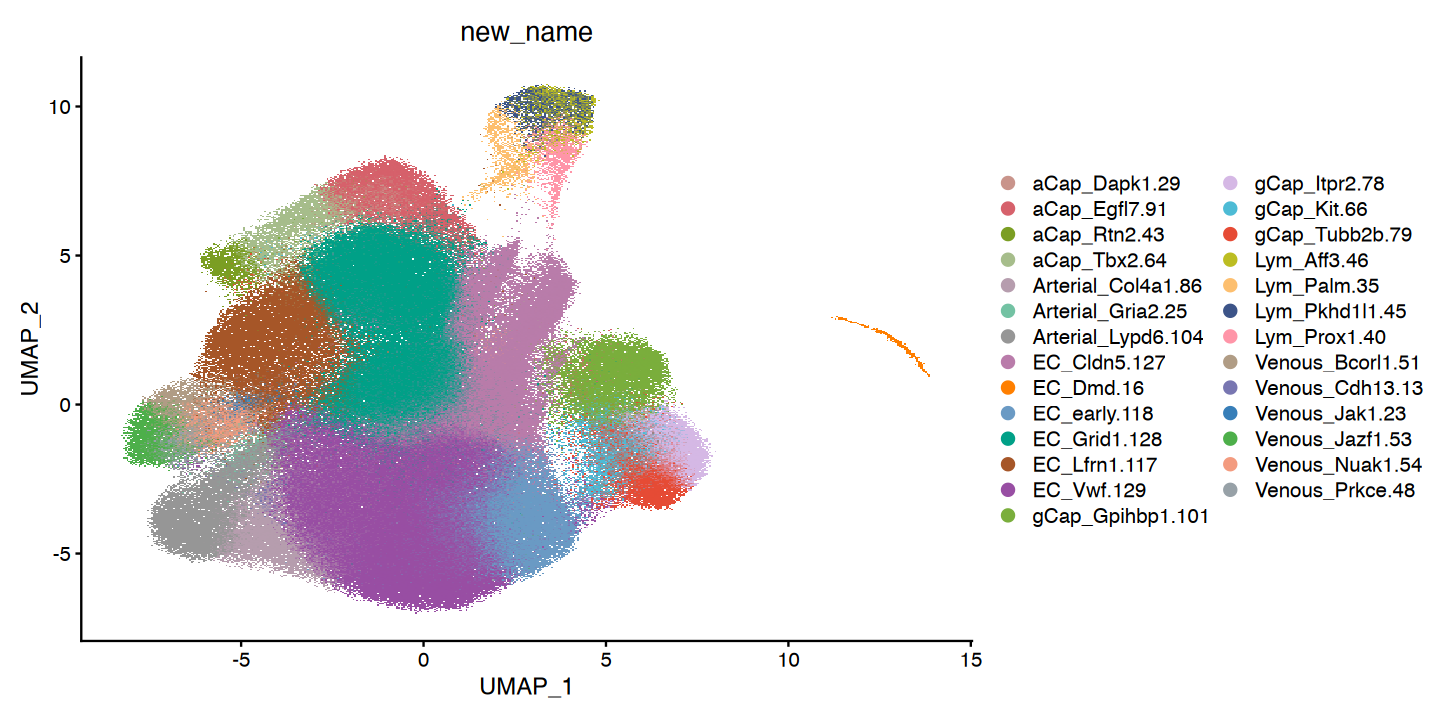

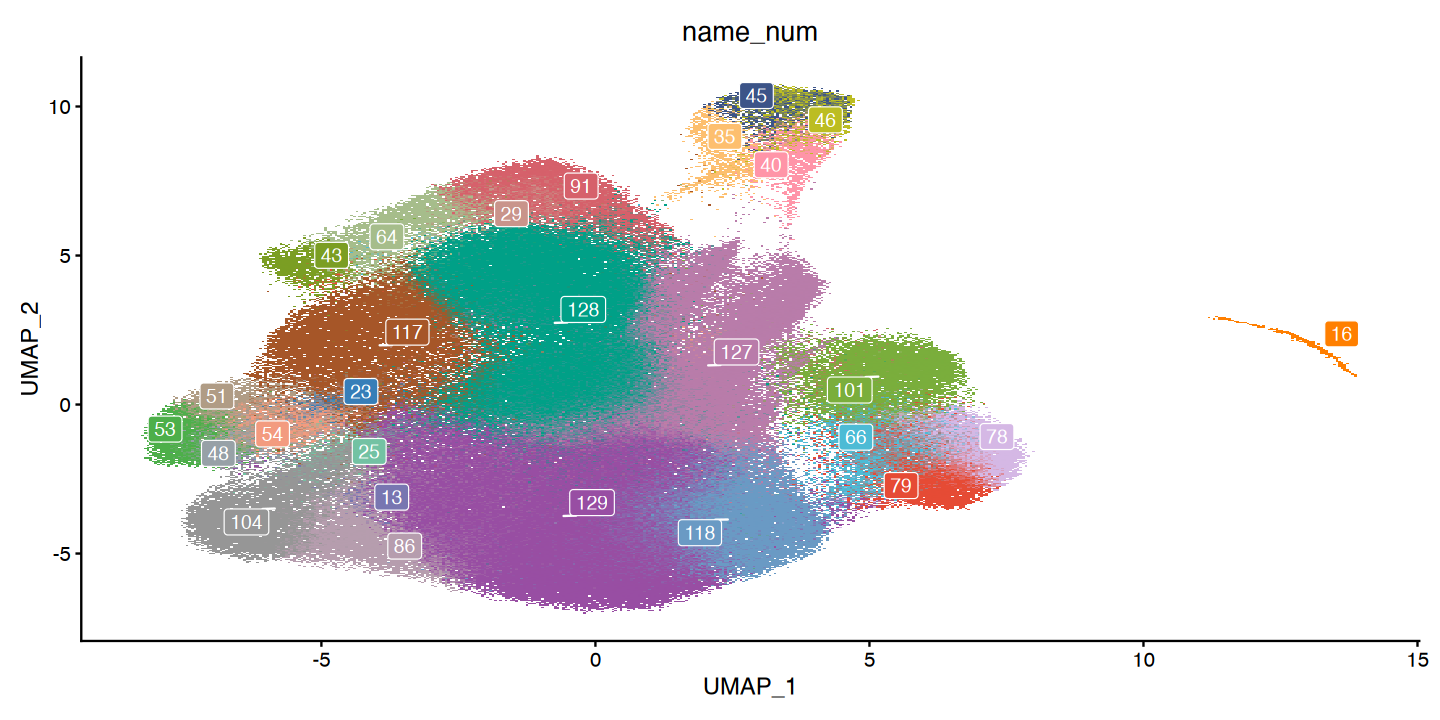

In [180]:
options(repr.plot.width=12, repr.plot.height=6)
a=DimPlot(tmp_srt_peak, reduction = 'umap', group.by = 'new_name', raster = T)+
    scale_colour_manual(values = round4_color)
#b=DimPlot(tmp_srt_peak, reduction = 'tsne', group.by = 'Celltype_round2', raster = T)
a
ggsave(glue('{output_dir}/Endo_round4_umap.pdf'), 
       a,
       width=8, height=6, units='in', dpi=600, bg='transparent')
options(repr.plot.width=12, repr.plot.height=6)
a=DimPlot(tmp_srt_peak, reduction = 'umap', group.by = 'name_num',
     raster = T, label = T, label.box=T,repel=T,label.color = "white", #alpha=0.5,
     cols=round4_color2)+NoLegend()
#b=DimPlot(tmp_srt_peak, reduction = 'tsne', group.by = 'Celltype_round2', raster = T)
a
ggsave(glue('{output_dir}/Endo_round4_umap(label).pdf'), 
       a,
       width=6, height=6, units='in', dpi=600, bg='transparent')

In [181]:
tmp_srt_gene <- NormalizeData(tmp_srt_gene, normalization.method = "LogNormalize", scale.factor = 10000)
tmp_srt_gene <- FindVariableFeatures(tmp_srt_gene, selection.method = "vst", nfeatures = 2000)
all.genes <- rownames(tmp_srt_gene)
tmp_srt_gene <- ScaleData(tmp_srt_gene, features = all.genes)
tmp_srt_gene

Normalizing layer: counts

Finding variable features for layer counts

Centering and scaling data matrix



An object of class Seurat 
17034 features across 181109 samples within 1 assay 
Active assay: RNA (17034 features, 2000 variable features)
 3 layers present: counts, data, scale.data
 2 dimensional reductions calculated: umap, tsne

In [ ]:
Idents(tmp_srt_gene) = tmp_srt_gene$Celltype_round4
gene_markers = FindAllMarkers(tmp_srt_gene, max.cells.per.ident = 300)

Calculating cluster EC_Vwf

Calculating cluster EC_Grid1

Calculating cluster EC_Arterial_Gria2

Calculating cluster EC_Arterial_Col4a1

Calculating cluster EC_gCap_Itpr2

Calculating cluster EC_early

Calculating cluster EC_gCap_Kit

Calculating cluster EC_endo

Calculating cluster EC_Arterial_Lypd6

Calculating cluster EC_Venous_Bcorl1

Calculating cluster EC_aCap_Egfl7

Calculating cluster EC_aCap

Calculating cluster EC_Lfrn1

Calculating cluster EC_Lymphatic

Calculating cluster EC_Lymphatic_Palm

Calculating cluster EC_gCap

Calculating cluster EC_aCap_Dapk1

Calculating cluster EC_Venous_Jazf1

Calculating cluster EC_gCap_Tubb2b

Calculating cluster EC_Lymphatic_Pkhd1l1

Calculating cluster EC_Lymphatic_Aff3

Calculating cluster EC_Venous_Prkce

Calculating cluster EC_Venous

Calculating cluster EC_aCap_Rtn2

Calculating cluster EC_Venous_Jak1

Calculating cluster EC_Venous_Cdh13

Calculating cluster Endothelium



In [ ]:
write.table(gene_markers, 
            file=glue('{output_dir}/Endo_round4_gene_markers.txt'),
            sep='\t', quote=F, row.names=F)

Scale for colour is already present.
Adding another scale for colour, which will replace the existing scale.
Scale for size is already present.
Adding another scale for size, which will replace the existing scale.


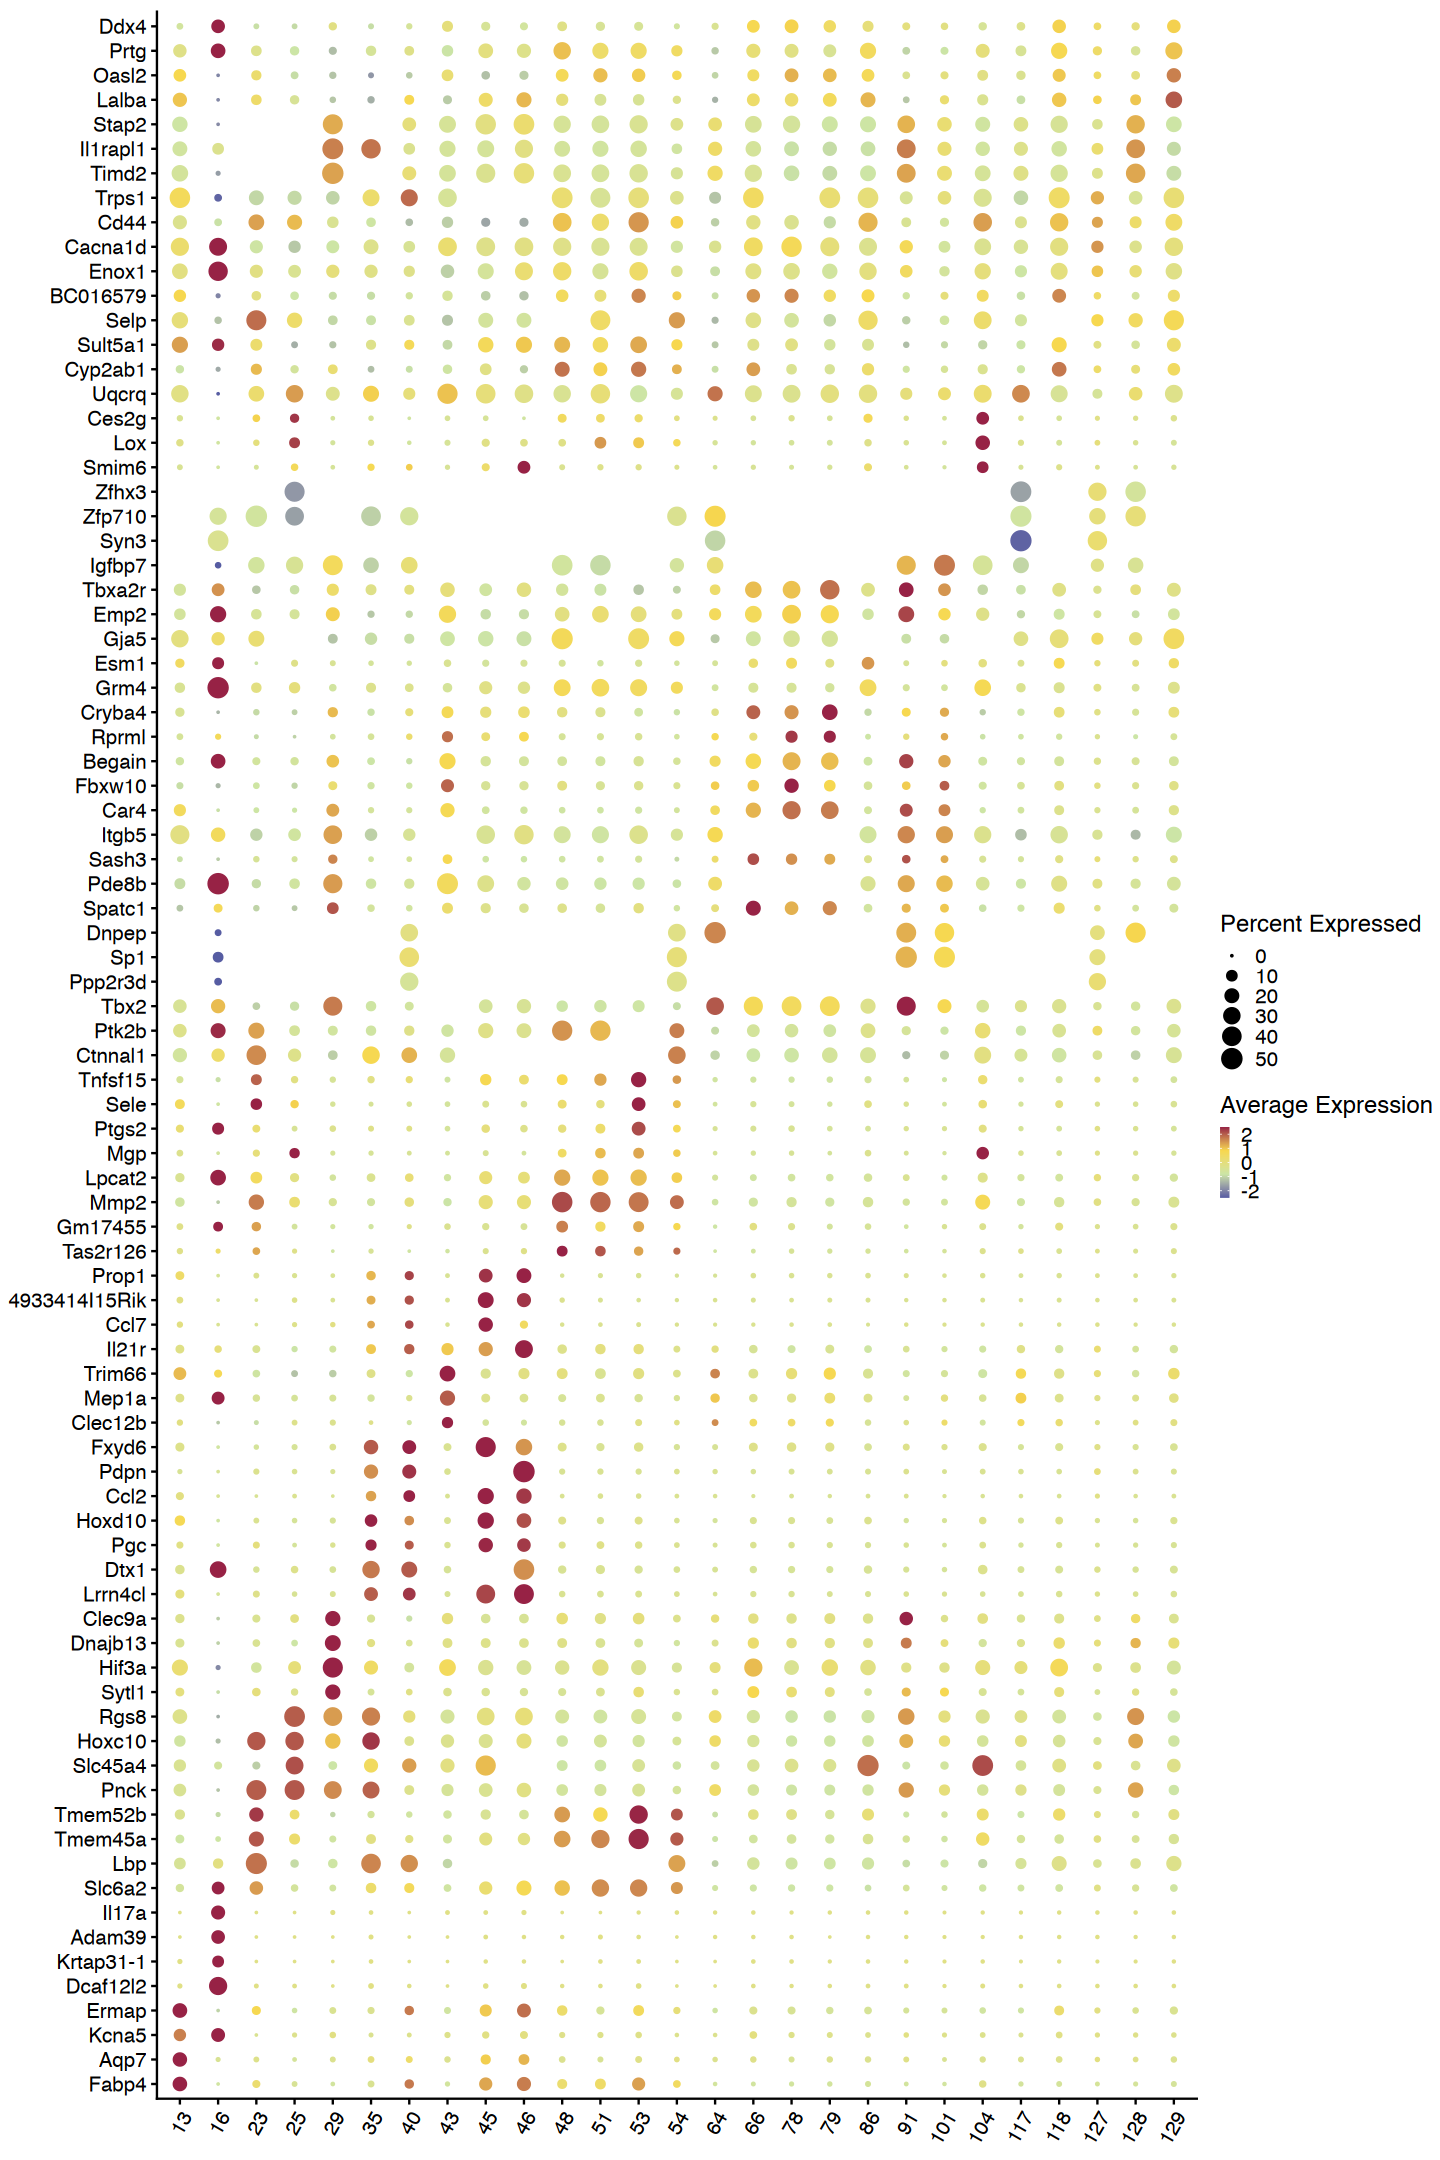

In [182]:
gene_markers = read.table(glue('{output_dir}/Endo_round4_gene_markers.txt'), header = T)
gene_markers$cluster = new_celltype[gene_markers$cluster, 'cluster_num']

top_peaks = gene_markers %>% 
    dplyr::filter(avg_log2FC >=0.25&p_val_adj <=0.05) %>%
    group_by(cluster) %>% 
    top_n(4,avg_log2FC) %>%
    arrange(cluster, -avg_log2FC)
cluster_order = sort(as.vector(unique(tmp_srt_gene$name_num)))
top_peaks$cluster = factor(top_peaks$cluster, levels=cluster_order)
top_peaks = top_peaks %>% arrange(cluster, -avg_log2FC)
tmp_srt_gene$name_num = factor(tmp_srt_gene$name_num, levels=cluster_order)
options(repr.plot.width=12, repr.plot.height=18)
a=DotPlot(tmp_srt_gene, 
        features = unique(top_peaks$gene),
        group.by='name_num')+
    scale_color_gradientn(colors = c('#565ca2','#cce5a6','#f7d84f','#972245'))+
    scale_size_continuous(range=c(0,5), limits = c(0,50))+
    #coord_flip()+
    theme(panel.grid = element_blank(),
        axis.text.x = element_text(angle = 60, hjust=1,vjust=1),
        axis.title = element_blank(),
        strip.background = element_blank(),
        legend.key.height = unit(3,'mm'),
        legend.key.size =  unit(2,'mm'))+
    coord_flip()
a

In [183]:
ggsave(glue('{output_dir}/Endo_round4_gene_dot.pdf'), 
       a,
       width=8, height=18, units='in', dpi=600, bg='transparent')